In [239]:
import math
import ast
import statistics
import numpy as np
import os
import csv
import json
from collections import defaultdict
import scipy.stats as stats
import matplotlib.pyplot as plt
import random as nd
import pickle as pkl
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\ProgramData\Anaconda3\envs\gym\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Main data parsing functions

In [240]:
def save_plot_data(obj, name, path):
    with open(path+name+'.pkl', 'wb') as f:
        pkl.dump(obj, f, pkl.HIGHEST_PROTOCOL)

def load_plot_data(name, path):
    with open(path+name+'.pkl', 'rb') as f:
        return pkl.load(f)

def load_json_data(inputfile):
    summ_data = []
    
    with open(inputfile) as json_file:
        summ_data = json.load(json_file)
        print('agent_ID: ' + summ_data['agent_ID'])
        #print('agent_type: ' + summ_data['agent_type'])
        #print('total_episodes: ' + str(summ_data['total_episodes']))
        #print('total_reward: ' + str(summ_data['total_reward']))
        #print('avg_rec_err: ' + str(summ_data['avg_rec_err']))
        #print('CL_ratio: ' + str(summ_data['CL_ratio']))
        #print('STM_length: ' + str(summ_data['STM_length']))
        #print('rec_thres: ' + str(summ_data['rec_thres']))
        #print('mean_step_rew: ' + str(summ_data['mean_step_rew']))
        #print('mean_step_log: ' + data['mean_step_log'])
        #print('wins_reactive: ' + str(summ_data['wins_reactive']))
        #print('wins_contextual: ' + str(summ_data['wins_contextual']))
        #print('auto_reliable: ' + str(summ_data['auto_reliable']))

    return summ_data

def load_csv_data(inputfile):

    # initializing the titles and rows list 
    fields = [] 
    data = [] 

    # reading csv file 
    with open(inputfile, 'r') as csvfile: 
        # creating a csv reader object 
        csvreader = csv.reader(csvfile) 

        # extracting field names through first row  
        fields = next(csvreader) 
        
        # printing the field names 
        print('Field names are: ' + ', '.join(field for field in fields)) 
        
        # extracting each data row one by one 
        for row in csvreader: 
            if len(row) > 0:
                data.append(row) 
               
        #print('Data length: ', len(data))

        # get total number of rows 
        print("Total no. of rows: %d"%(csvreader.line_num)) 
    
    print("Data length: ", len(data))  

    return data

def get_reward_ep(data):
    reward_ep = []
    for d in data:
        reward_ep.append(d[0])
    return reward_ep

def get_rec_error_mean(data):
    rec_error_mean = []
    for d in data:
        rec_error_mean.append(d[1])
    return rec_error_mean

def get_reward_logs(data):
    reward_logs = []
    for d in data:
        reward_logs.append(d[2])
    return reward_logs

def get_rec_error_logs(data):
    rec_error_logs = []
    for d in data:
        rec_error_logs.append(d[3])
    return rec_error_logs

def get_agent_speed_logs(data):
    agent_speed_logs = []
    for d in data:
        agent_speed_logs.append(d[4])
    return agent_speed_logs

def get_agent_pos_logs(data):
    agent_pos_logs = []
    for d in data:
        agent_pos_logs.append(d[5])
    return agent_pos_logs

def get_active_layer_logs(data, model):
    active_layer_logs = []
    for d in data:
        active_layer_logs.append(d[5])
        #active_layer_logs.append(d[6]) if model != 'MFEC' else active_layer_logs.append(d[5])
    return active_layer_logs

def get_entropy_logs(data, model):
    entropy_logs = []
    for d in data:
        entropy_logs.append(d[6])
        #if model != 'MFEC': entropy_logs.append(d[7]) 
    return entropy_logs

def get_action_sel_logs(data, model):
    action_sel_logs = []
    for d in data:
        action_sel_logs.append(d[7])
        #action_sel_logs.append(d[8]) if model != 'MFEC' else action_sel_logs.append(d[6])
    return action_sel_logs

def get_reward_ts(reward_ep, ltm_length):
    #ltm = int(ltm_length[3:])
    ltm = ltm_length

    abs_tru_reward_ts = []
    abs_rnd_reward_ts = []
    acc_tru_reward = 0
    acc_tru_reward_ts = []
    acc_rnd_reward = 0
    acc_rnd_reward_ts = []
    count_ltm = 0
    index_eps = 0
    ltm_complete = 0
    
    for episode in reward_ep:
        #print(episode)
        r = float(episode)
        
        #print(r)
        if r > 0:
            #print(r)
            abs_tru_reward_ts.append(r)
            abs_rnd_reward_ts.append(3)
            acc_tru_reward += r
            acc_rnd_reward += 3
            count_ltm += 1
        else:
            abs_tru_reward_ts.append(0)
            abs_rnd_reward_ts.append(0)
            acc_tru_reward += 0
            acc_rnd_reward += 0
            
        if count_ltm == ltm: 
            ltm_complete = index_eps
            ltm = -1
            
        acc_tru_reward_ts.append(acc_tru_reward)
        acc_rnd_reward_ts.append(acc_rnd_reward)
        index_eps += 1
        
    return abs_tru_reward_ts, abs_rnd_reward_ts, acc_tru_reward_ts, acc_rnd_reward_ts, ltm_complete


def get_steps_ts(reward_ep, steps_data, cl=4):
    #default episode total actions: 
    # CL4 - 251, CL2 - 501, # CL1 - 1001
    #print(cl[1])
    #default_steps = round(1000 / int(cl[1:]))
    default_steps = round(1000 / cl)
    steps_index = 0
    ep_steps_ts = []
    acc_steps = 0
    acc_steps_ts = []
    steps = steps_data
    #steps = json_data['mean_step_log']
    #for episode in reward_ep:
    for episode in reward_ep:
        #print(episode)
        r = float(episode)
        #print(r)
        if r > 0:
            ep_steps_ts.append(int(steps[steps_index]))
            acc_steps += int(steps[steps_index])
            steps_index += 1 
        else:
            ep_steps_ts.append(default_steps)
            acc_steps += default_steps
            
        acc_steps_ts.append(acc_steps)    
                    
    return ep_steps_ts, acc_steps_ts

def get_condition_data(cl, stm):
    data = []
    for r,d,f in os.walk(base_path):
        for files in f:
            if files.startswith('c'+str(cl)+'-stm'+str(stm)) and files.endswith('.csv'):
                #ts = []
                inputfile = r + files
                print("r: ", r)
                data = load_data(inputfile)
    return data


def get_layer_reliance_ep(layer_logs):
    reactive_reliance = []
    contextual_reliance = []
    episode_dominance = []
    episode_last = []
    for ep in layer_logs:
        contextual = 0
        reactive = 0
        for d in ep:
            if d == 'C': contextual += 1
            if d == 'R': reactive += 1
        if contextual >= reactive: episode_dominance.append('C')
        else: episode_dominance.append('R')
        if (reactive+contextual) > 0:
            rel_reactive = reactive / (reactive+contextual)
            rel_contextual = contextual / (reactive+contextual)
        else:
            rel_reactive = 0
            rel_contextual = 0
        reactive_reliance.append(rel_reactive)
        contextual_reliance.append(rel_contextual)
        episode_last.append(ep[-3])
    return episode_dominance, episode_last, reactive_reliance, contextual_reliance


def get_layer_reward_ts_last(reward_ep, steps_data, ep_last):
    count_reactive = 0
    abs_reward_reactive = []
    abs_reward_contextual = []
    acc_contextual_reward = 0
    acc_reactive_reward = 0
    acc_reward_reactive = []
    acc_reward_contextual = []
    #count_steps = 0
    steps_reactive = []
    steps_contextual = []
    steps = steps_data
    #steps = json_data['mean_step_log']
    #for episode in reward_ep:
    for i in range (len(reward_ep)):
        #print(episode)
        r = float(reward_ep[i])
        #print(r)
        if r >= 1.:
            #if count_reactive > 4:
            if ep_last[i] == 'R':
                acc_reactive_reward += r
                abs_reward_reactive.append(r)
                acc_reward_reactive.append(acc_reactive_reward)
                steps_reactive.append(steps[count_reactive])
                
                abs_reward_contextual.append(0)
                acc_reward_contextual.append(acc_contextual_reward)
            else:
                acc_contextual_reward += r
                abs_reward_contextual.append(r)
                acc_reward_contextual.append(acc_contextual_reward)
                steps_contextual.append(steps[count_reactive])  
                
                abs_reward_reactive.append(0)
                acc_reward_reactive.append(acc_reactive_reward)
                    
            count_reactive += 1                
            #count_steps += 1  
        
    return abs_reward_reactive, acc_reward_reactive, abs_reward_contextual, acc_reward_contextual, steps_reactive, steps_contextual

def get_mean_entropy(data):
    mean_entropy_ep = []
    for d in data:
        #a = np.fromstring(d[1:-1], dtype=float, sep=',')
        float_array = ast.literal_eval(d)
        mean_entropy = np.mean(float_array)
        mean_entropy_ep.append(mean_entropy)
    return mean_entropy_ep

def get_encoder_reliability_ts(rec_error_logs, rec_thresh=0):
    data = rec_error_logs
    reconstruct_thres = rec_thresh
    encoder_reliability_ts = []

    for ep in data:
        a = np.fromstring(ep[1:-1], dtype=float, sep=',')
        #print(len(a))
        count_reliable = 0
        count_unreliable = 0
        encoder_reliability = 0
        for rec_error_ts in a:
            if rec_error_ts < reconstruct_thres: 
                #print ('Reconstruction Error RELIABLE')
                count_reliable +=1  
            else:
                #print ('Reconstruction Error UNRELIABLE') 
                count_unreliable +=1
        encoder_reliability = (count_reliable / (count_reliable+count_unreliable)) * 100
        encoder_reliability_ts.append(encoder_reliability)
    return encoder_reliability_ts

In [221]:
def get_condition_dac(filepath, model, ltm_length=500):
    
    agent = "dac"
    indx = 0
    jsn_data = 0
    agent_ID = ""
    
    rec_threshold=0.01

    #big_list = []
    big_json = []
    big_steps = []
    big_autoencoder_trust_rel, big_autoencoder_trust_ts = [], []
    big_reward_ep = []
    big_abs_tru_reward, big_abs_rnd_reward, big_acc_tru_reward, big_acc_rnd_reward = [], [], [], []
    big_layer_data = []
    big_ep_dominance, big_ep_last, big_reactive_rel, big_contextual_rel =  [], [], [], []
    big_abs_rew_reactive, big_acc_rew_reactive, big_abs_rew_contextual, big_acc_rew_contextual, big_steps_reactive, big_steps_contextual = [], [], [], [], [], []
    big_rec_error_logs = []
    big_wins_reactive, big_wins_contextual = [], []
    #big_autoencoder_trust_ts = []  
    big_entropy_data, big_mean_entropy = [], []
    big_real_steps, big_acc_steps = [], []
    big_ltm_complete = []
    big_pos = []

    print(filepath+'{0}/'.format(model))
    for r,d,f in os.walk(filepath+'{0}/'.format(model)):
        #print("oink! 0")
        for files in f:
            if files.endswith('.json'):
                filename = r+'/'+files
                jsn_data = load_json_data(filename)
                agent_ID = jsn_data['agent_ID']
                big_json.append(jsn_data)
                big_autoencoder_trust_rel.append(jsn_data['auto_reliable'])
                mean_steps_log = jsn_data['mean_step_log']
                big_steps.append(mean_steps_log)
                big_wins_reactive.append(jsn_data['wins_reactive'])
                big_wins_contextual.append(jsn_data['wins_contextual'])
                #print("oink! 1: ", agent_ID)
                for r,d,f in os.walk(filepath+'{0}/'.format(model)):
                    #print("oink! 2a")
                    for files in f:
                        if files.startswith(agent_ID) and files.endswith('.csv'):
                            #print("oink! 2b: ", agent_ID)
                            filename = r+'/'+files
                            #print("oink! 2c: ", filename)
                            csv_data = load_csv_data(filename)
                            reward_ep = get_reward_ep(csv_data)
                            big_reward_ep.append(reward_ep)
                            abs_tru_reward, abs_rnd_reward, acc_tru_reward, acc_rnd_reward, ltm_full = get_reward_ts(reward_ep, ltm_length)
                            big_abs_tru_reward.append(abs_tru_reward)
                            big_abs_rnd_reward.append(abs_rnd_reward)
                            big_acc_tru_reward.append(acc_tru_reward)
                            big_acc_rnd_reward.append(acc_rnd_reward)
                            big_ltm_complete.append(ltm_full)
                            layer_data = get_active_layer_logs(csv_data, model)
                            big_layer_data.append(layer_data)
                            ep_dominance, ep_last, reactive_rel, contextual_rel = get_layer_reliance_ep(layer_data)
                            big_ep_dominance.append(ep_dominance)
                            big_ep_last.append(ep_last)
                            big_reactive_rel.append(reactive_rel)
                            big_contextual_rel.append(contextual_rel)
                            abs_rew_reactive, acc_rew_reactive, abs_rew_contextual, acc_rew_contextual, steps_reactive, steps_contextual = get_layer_reward_ts_last(reward_ep, mean_steps_log, ep_dominance)
                            big_abs_rew_reactive.append(abs_rew_reactive)
                            big_acc_rew_reactive.append(acc_rew_reactive)
                            big_abs_rew_contextual.append(abs_rew_contextual)
                            big_acc_rew_contextual.append(acc_rew_contextual)
                            big_steps_reactive.append(steps_reactive)
                            big_steps_contextual.append(steps_contextual)
                            real_steps_ts, acc_steps_ts = get_steps_ts(reward_ep, mean_steps_log)
                            big_real_steps.append(real_steps_ts)
                            big_acc_steps.append(acc_steps_ts)
                            if model != "reactive": 
                                rec_error_logs = get_rec_error_logs(csv_data)
                                big_rec_error_logs.append(rec_error_logs)
                                autoencoder_trust_ts = get_encoder_reliability_ts(rec_error_logs, rec_threshold)
                                #big_autoencoder_trust_ts.apppend(autoencoder_trust_ts)
                                entropy_data = get_entropy_logs(csv_data, model)
                                mean_entropy = get_mean_entropy(entropy_data)
                                big_entropy_data.append(entropy_data)
                                big_mean_entropy.append(mean_entropy)
                            #if model == "dac-pos" or model == "dac-nobias-pos":
                                #agent_pos_logs = get_agent_pos_logs(csv_data)
                                #big_pos.append(agent_pos_logs)
                            indx += 1
                      
    big_list = {}

    #big_list['agent_ID'] = ID
    big_list['abs_tru_reward'] = big_abs_tru_reward
    big_list['acc_tru_reward'] = big_acc_tru_reward  #this
    big_list['reward_steps_ts'] = big_steps
    big_list['real_steps_ts'] = big_real_steps  #this
    big_list['acc_steps_ts'] = big_acc_steps  #this
    big_list['mean_entropy'] = big_mean_entropy #this
    big_list['LTM_full'] = big_ltm_complete
    #big_list['position_ts'] = big_pos

    #big_list['autoencoder_trust_ts'] = big_autoencoder_trust_ts
    big_list['reactive_relact'] = big_reactive_rel    
    big_list['contextual_relact'] = big_contextual_rel  #this
    big_list['reactive_wins'] = big_wins_reactive    
    big_list['contextual_wins'] = big_wins_contextual  
    
    big_list['abs_rew_reactive'] = big_abs_rew_reactive
    big_list['abs_rew_contextual'] = big_abs_rew_contextual
    big_list['acc_rew_reactive'] = big_acc_rew_reactive
    big_list['acc_rew_contextual'] = big_acc_rew_contextual      
 
    big_list['steps_reactive'] = big_steps_reactive
    big_list['steps_contextual'] = big_steps_contextual    
    
    return big_list

# Parse single condition

In [207]:
#file_path = 'E:/SEC_paper_data/exp3/'
file_path = '../data/exp3_ablations/'
plot_path = '../results/'

In [244]:
file_path = '../data/exp4_forgetting/'
plot_path = '../data/exp4_forgetting/'

In [245]:
model = 'SEC_500_forgetPRIOR'
data = get_condition_dac(file_path, model)

../data/exp4_forgetting/SEC_500_forgetPRIOR/
agent_ID: SEC_doubleTmaze_cl4-stm50-ltm500_agent-0595hp_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 5001
Data length:  5000
agent_ID: SEC_doubleTmaze_cl4-stm50-ltm500_agent-0lc2rc_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 5001
Data length:  5000
agent_ID: SEC_doubleTmaze_cl4-stm50-ltm500_agent-0wiyya_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 5001
Data length:  5000
agent_ID: SEC_doubleTmaze_cl4-stm50-ltm500_agent-2bpq5a_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 5001
Data length:  

In [110]:
len(data['abs_tru_reward'][0])
np.sum(data['abs_tru_reward'][2])

11867.504277226515

In [111]:
len(data['mean_entropy'])

16

In [112]:
data['mean_entropy'][0][-1]

0.0

In [113]:
for i in range (len(data['mean_entropy'])):
    print(data['mean_entropy'][i][-1])

0.0
0.49967340025762175
0.07415398942690511
0.07333306109080069
0.2596167940878111
0.364816961430128
0.030441093690193228
0.031410908350401466
0.032577566761525754
0.450653956772087
0.009043578461696311
0.05553734431505887
0.03221511083679003
0.01567724184248921
0.0
0.7595318752767313


In [114]:
len(data)

17

In [246]:
save_plot_data(data, model, file_path)

In [247]:
data.keys()

dict_keys(['abs_tru_reward', 'acc_tru_reward', 'reward_steps_ts', 'real_steps_ts', 'acc_steps_ts', 'mean_entropy', 'LTM_full', 'reactive_relact', 'contextual_relact', 'reactive_wins', 'contextual_wins', 'abs_rew_reactive', 'abs_rew_contextual', 'acc_rew_reactive', 'acc_rew_contextual', 'steps_reactive', 'steps_contextual'])

# Parse all conditions

In [222]:
models = ['default', 'fifo', 'fifo1000', 'noGi', 'noGi_new', 'noDist', 'noRR', 'soloGi', 'soloDist', 'soloRR']
data = {}

In [223]:
for model in models:
    data[model] = get_condition_dac(file_path, model)
    save_plot_data(data[model], model, file_path)

../data/exp3_ablations/default/
agent_ID: cl4-stm50-ltm500_agent-0fu2jc_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 5001
Data length:  5000
agent_ID: cl4-stm50-ltm500_agent-1z4bk1_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 5001
Data length:  5000
agent_ID: cl4-stm50-ltm500_agent-6pmdcg_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 5001
Data length:  5000
agent_ID: cl4-stm50-ltm500_agent-9daths_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 5001
Data length:  5000
agent_ID: cl4-stm50-ltm500_agent-frfi3q_
Field names are: reward_ep, rec

Total no. of rows: 10002
Data length:  5000
agent_ID: SEC_doubleTmaze_cl4-stm50-ltm1000_agent-e95hpa_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 10002
Data length:  5000
agent_ID: SEC_doubleTmaze_cl4-stm50-ltm1000_agent-eo6rza_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 10002
Data length:  5000
agent_ID: SEC_doubleTmaze_cl4-stm50-ltm1000_agent-zh48mc_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 10002
Data length:  5000
../data/exp3_ablations/noGi/
agent_ID: cl4-stm50-ltm500_agent-2awesw_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 5

Total no. of rows: 10002
Data length:  5000
agent_ID: cl4-stm50-ltm500_agent-oe9rwa_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 5001
Data length:  5000
agent_ID: cl4-stm50-ltm500_agent-p4wwzo_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 5001
Data length:  5000
agent_ID: cl4-stm50-ltm500_agent-rk8p5z_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 5001
Data length:  5000
agent_ID: cl4-stm50-ltm500_agent-t93bi0_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 10002
Data length:  5000
agent_ID: cl4-stm50-ltm500_agent-tkhgxo_
Field names are: r

Total no. of rows: 5001
Data length:  5000
agent_ID: cl4-stm50-ltm500_agent-156syy_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 5001
Data length:  5000
agent_ID: cl4-stm50-ltm500_agent-53micz_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 5001
Data length:  5000
agent_ID: cl4-stm50-ltm500_agent-5yra98_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 10002
Data length:  5000
agent_ID: cl4-stm50-ltm500_agent-amgts6_
Field names are: reward_ep, rec_error_mean, reward_logs, rec_error_logs, agent_speed_logs, active_layer_logs, entropy_logs, action_sel_logs
Total no. of rows: 10002
Data length:  5000
agent_ID: cl4-stm50-ltm500_agent-gx5wic_
Field names are: r

In [224]:
len(data)

10

In [225]:
save_plot_data(data, 'data_new', file_path)

In [55]:
data = load_plot_data('MFEC-ae', file_path)

In [56]:
data.keys()

dict_keys(['abs_tru_reward', 'acc_tru_reward', 'reward_steps_ts', 'real_steps_ts', 'acc_steps_ts', 'mean_entropy', 'LTM_full', 'reactive_relact', 'contextual_relact', 'reactive_wins', 'contextual_wins', 'abs_rew_reactive', 'abs_rew_contextual', 'acc_rew_reactive', 'acc_rew_contextual', 'steps_reactive', 'steps_contextual'])

In [57]:
data['mean_entropy'][0]

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

# Save parsed data for future use

In [226]:
#data = load_plot_data('DQN', file_path)
#file_path = 'E:/SEC_paper_data/exp3/'
file_path = '../data/exp3_ablations/'
plot_path = '../results/'

In [250]:
file_path = '../data/exp4_forgetting/'
model = 'SEC_500_forgetPRIOR'
SEC_500_forgetPRIOR = load_plot_data('SEC_500_forgetPRIOR', file_path)
SEC_500_forgetPRIOR.keys()

dict_keys(['abs_tru_reward', 'acc_tru_reward', 'reward_steps_ts', 'real_steps_ts', 'acc_steps_ts', 'mean_entropy', 'LTM_full', 'reactive_relact', 'contextual_relact', 'reactive_wins', 'contextual_wins', 'abs_rew_reactive', 'abs_rew_contextual', 'acc_rew_reactive', 'acc_rew_contextual', 'steps_reactive', 'steps_contextual'])

In [ ]:
data['SEC-PRIOR'] = SEC_500_forgetPRIOR
data.keys()

In [227]:
#file_path = '../saved_data/exp3/'
#D:\SPECS\Assets\SEC_code_ocean\sec\data\exp4_forgetting
file_path = '../data/exp3_ablations/'
plot_path = '../exp3_ablations/'
data = load_plot_data('data_new',file_path)

In [228]:
data.keys()

dict_keys(['default', 'fifo', 'fifo1000', 'noGi', 'noGi_new', 'noDist', 'noRR', 'soloGi', 'soloDist', 'soloRR'])

In [152]:
data['SEC-RWD_v3'] = data_forgetRWD
data.keys()

dict_keys(['MFEC', 'SEC', 'SEC-FIFO', 'SEC-RWD', 'NSEC', 'NSEC-FIFO', 'NSEC-RWD', 'SEC-FIFO_v2', 'SEC-RWD_v2', 'SEC-RWD_v3'])

In [153]:
data['SEC-RWD_v3'].keys()

dict_keys(['abs_tru_reward', 'acc_tru_reward', 'reward_steps_ts', 'real_steps_ts', 'acc_steps_ts', 'mean_entropy', 'LTM_full', 'reactive_relact', 'contextual_relact', 'reactive_wins', 'contextual_wins', 'abs_rew_reactive', 'abs_rew_contextual', 'acc_rew_reactive', 'acc_rew_contextual', 'steps_reactive', 'steps_contextual'])

In [69]:
# New names mapping
new_names = {
    'cl4_stm50_ltm500_ep5K_mfec': 'MFEC',
    'cl4_stm50_ltm500_ep5K_dac-pos': 'SEC',
    'cl4_stm50_ltm500_ep5K_dac-pos-fifo': 'SEC-FIFO',
    'cl4_stm50_ltm500_ep5K_dac-pos-sing': 'SEC-RWD',
    'cl4_stm50_ltm500_ep5K_dac-nobias-pos': 'NSEC',
    'cl4_stm50_ltm500_ep5K_dac-nobias-fifo': 'NSEC-FIFO',
    'cl4_stm50_ltm500_ep5K_dac-nobias-sing': 'NSEC-RWD',
    'cl4_stm50_ltm500_ep5K_dac-fifo': 'SEC-FIFO_v2',
    'cl4_stm50_ltm500_ep5K_dac-sing': 'SEC-RWD_v2',
    'cl4_stm50_ltm500_ep5K_dac-pos-sing-v2': 'SEC-RWD_v3'
}

# Renaming process
new_data = {new_names[old_key]: data[old_key] for old_key in data.keys()}

# Now 'new_data' contains the renamed keys
print(new_data.keys())

dict_keys(['MFEC', 'SEC', 'SEC-FIFO', 'SEC-RWD', 'NSEC', 'NSEC-FIFO', 'NSEC-RWD', 'SEC-FIFO_v2', 'SEC-RWD_v2', 'SEC-RWD_v3'])


In [154]:
file_path = '../data/exp4_forgetting/'
save_plot_data(data, 'data_new', file_path)

In [155]:
data['SEC-RWD_v3'].keys()

dict_keys(['abs_tru_reward', 'acc_tru_reward', 'reward_steps_ts', 'real_steps_ts', 'acc_steps_ts', 'mean_entropy', 'LTM_full', 'reactive_relact', 'contextual_relact', 'reactive_wins', 'contextual_wins', 'abs_rew_reactive', 'abs_rew_contextual', 'acc_rew_reactive', 'acc_rew_contextual', 'steps_reactive', 'steps_contextual'])

In [251]:
file_path = '../data/exp4_forgetting/'
data = load_plot_data('data_new',file_path)
data['SEC-PRIOR'] = SEC_500_forgetPRIOR
data.keys()

In [253]:
data['SEC-PRIOR'] = SEC_500_forgetPRIOR
data.keys()

dict_keys(['MFEC', 'SEC', 'SEC-FIFO', 'SEC-RWD', 'NSEC', 'NSEC-FIFO', 'NSEC-RWD', 'SEC-FIFO_v2', 'SEC-RWD_v2', 'SEC-RWD_v3', 'SEC-RWD_v4', 'SEC-PRIOR'])

In [254]:
data.keys()

dict_keys(['MFEC', 'SEC', 'SEC-FIFO', 'SEC-RWD', 'NSEC', 'NSEC-FIFO', 'NSEC-RWD', 'SEC-FIFO_v2', 'SEC-RWD_v2', 'SEC-RWD_v3', 'SEC-RWD_v4', 'SEC-PRIOR'])

In [256]:
#models = ['default', 'fifo', 'noGi', 'noGi_new', 'noDist', 'noRR', 'soloGi', 'soloDist', 'soloRR']
models = ['MFEC', 'SEC', 'SEC-FIFO', 'SEC-RWD', 'NSEC', 'NSEC-FIFO', 'NSEC-RWD', 'SEC-FIFO_v2', 'SEC-RWD_v2', 'SEC-RWD_v3', 'SEC-RWD_v4']
models = ['MFEC', 'SEC', 'SEC-FIFO', 'SEC-RWD', 'NSEC', 'NSEC-FIFO', 'NSEC-RWD', 'SEC-FIFO_v2', 'SEC-RWD_v2', 'SEC-RWD_v3', 'SEC-RWD_v4', 'SEC-PRIOR']
#data = {}

for model in models:
    #model_data = load_plot_data(model, file_path)
    save_plot_data(data[model], model, file_path)
    

In [22]:
models = ['default', 'fifo', 'noGi', 'noGi_new', 'noDist', 'noRR', 'soloGi', 'soloDist', 'soloRR']

data = {}

for model in models:
    model_data = load_plot_data(model, file_path)
    data[model] = model_data
    

In [163]:
data.keys()

dict_keys(['MFEC', 'SEC', 'SEC-FIFO', 'SEC-RWD', 'NSEC', 'NSEC-FIFO', 'NSEC-RWD', 'SEC-FIFO_v2', 'SEC-RWD_v2', 'SEC-RWD_v3'])

In [255]:
save_plot_data(data, 'data_new', file_path)

In [257]:
data = load_plot_data('data_new', file_path)

In [258]:
data.keys()

dict_keys(['MFEC', 'SEC', 'SEC-FIFO', 'SEC-RWD', 'NSEC', 'NSEC-FIFO', 'NSEC-RWD', 'SEC-FIFO_v2', 'SEC-RWD_v2', 'SEC-RWD_v3', 'SEC-RWD_v4', 'SEC-PRIOR'])

In [166]:
data['SEC-RWD_v3'].keys()

dict_keys(['abs_tru_reward', 'acc_tru_reward', 'reward_steps_ts', 'real_steps_ts', 'acc_steps_ts', 'mean_entropy', 'LTM_full', 'reactive_relact', 'contextual_relact', 'reactive_wins', 'contextual_wins', 'abs_rew_reactive', 'abs_rew_contextual', 'acc_rew_reactive', 'acc_rew_contextual', 'steps_reactive', 'steps_contextual'])

In [167]:
data['SEC-RWD_v2'].keys()

dict_keys(['abs_tru_reward', 'acc_tru_reward', 'reward_steps_ts', 'real_steps_ts', 'acc_steps_ts', 'mean_entropy', 'LTM_full', 'reactive_relact', 'contextual_relact', 'reactive_wins', 'contextual_wins', 'abs_rew_reactive', 'abs_rew_contextual', 'acc_rew_reactive', 'acc_rew_contextual', 'steps_reactive', 'steps_contextual'])

In [142]:
SEC_500_forgetRWD = load_plot_data('SEC_500_forgetRWD', file_path)

In [143]:
SEC_500_forgetRWD.keys()

dict_keys(['abs_tru_reward', 'acc_tru_reward', 'reward_steps_ts', 'real_steps_ts', 'acc_steps_ts', 'mean_entropy', 'LTM_full', 'reactive_relact', 'contextual_relact', 'reactive_wins', 'contextual_wins', 'abs_rew_reactive', 'abs_rew_contextual', 'acc_rew_reactive', 'acc_rew_contextual', 'steps_reactive', 'steps_contextual'])

# Rewards - single

In [144]:
# Variables a computar para reward plot
window_width = 20
data_trureward = SEC_500_forgetRWD['abs_tru_reward']
data_trureward = np.asarray(data_trureward, dtype=np.float32)

mean = np.mean(data_trureward, axis=0)
yerr = np.std(data_trureward, axis=0) / math.sqrt(len(data_trureward))

data_trureward_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
data_trureward_mavecr = (data_trureward_cumsum[window_width:] - data_trureward_cumsum[:-window_width]) / window_width

data_trureward_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
data_trureward_mavecr_std = (data_trureward_cumsum_std[window_width:] - data_trureward_cumsum_std[:-window_width]) / window_width

min_val = data_trureward_mavecr - data_trureward_mavecr_std
max_val = data_trureward_mavecr + data_trureward_mavecr_std
length = data_trureward_mavecr_std.shape[0]


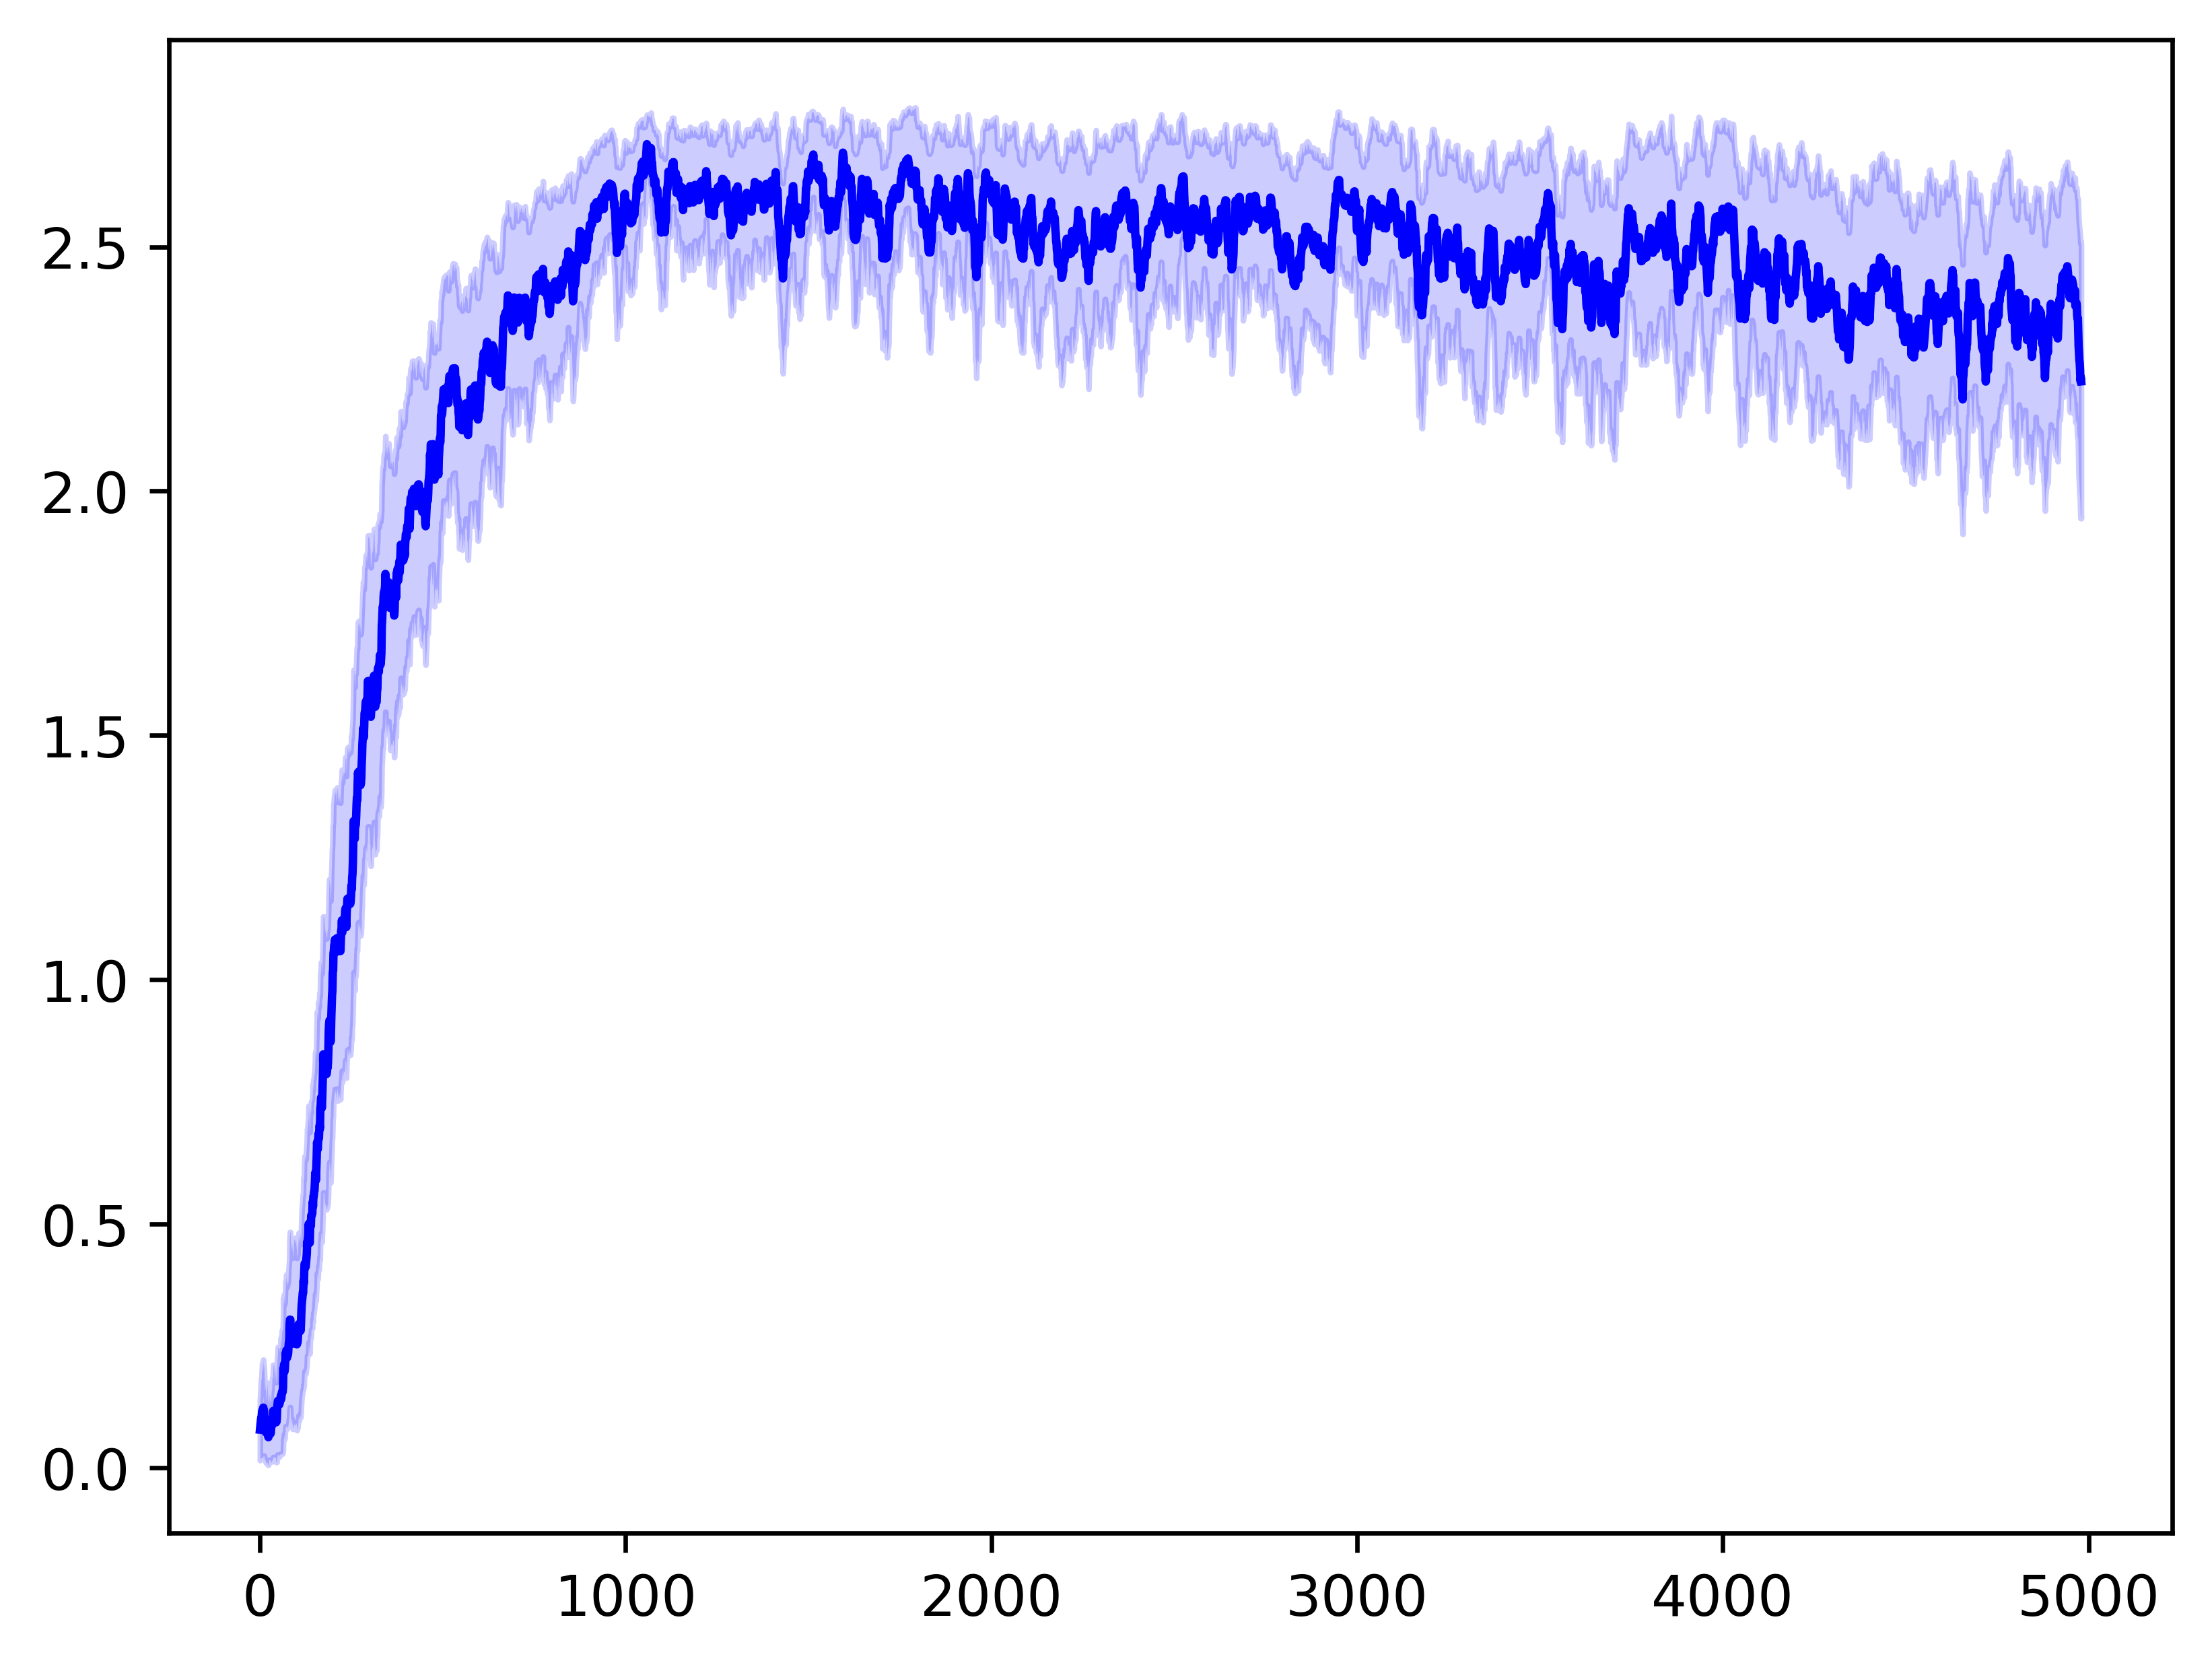

In [145]:
# Variables a guardar para reward plot
plt.plot(data_trureward_mavecr, label="DAC-ML", color='blue')

plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

# Rewards - all

In [259]:
models = ['default', 'fifo', 'fifo1000', 'noGi', 'noGi_new', 'noDist', 'noRR', 'soloGi', 'soloDist', 'soloRR']
#models = ['MFEC', 'SEC', 'SEC-FIFO', 'SEC-RWD', 'NSEC', 'NSEC-FIFO', 'NSEC-RWD', 'SEC-FIFO_v2', 'SEC-RWD_v2', 'SEC-RWD_v3']
models = ['MFEC', 'SEC', 'SEC-FIFO', 'SEC-RWD', 'NSEC', 'NSEC-FIFO', 'NSEC-RWD', 'SEC-FIFO_v2', 'SEC-RWD_v2', 'SEC-RWD_v3', 'SEC-RWD_v4', 'SEC-PRIOR']
ltm = 500

In [260]:
reward_data = {}
#ltm_data = {}
window_width = 20


for model in models:

    data_trureward = data[model]['abs_tru_reward']
    data_trureward = np.asarray(data_trureward, dtype=np.float32)
    print("data_truerward_sum ", np.sum(data_trureward))

    if np.sum(data_trureward) > 0:
        if len(data_trureward[0]) > 5000: 
            data_half = np.hsplit(data_trureward, 2)
            data_trureward = data_half[0]

        mean = np.mean(data_trureward, axis=0)
        yerr = np.std(data_trureward, axis=0) / math.sqrt(len(data_trureward))

        data_trureward_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
        data_trureward_mavecr = (data_trureward_cumsum[window_width:] - data_trureward_cumsum[:-window_width]) / window_width

        data_trureward_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
        data_trureward_mavecr_std = (data_trureward_cumsum_std[window_width:] - data_trureward_cumsum_std[:-window_width]) / window_width

        data_totalreward = np.sum(data_trureward, axis=1) 
        #data_totalreward_mean = np.mean(data_totalreward)
        #data_totalreward_std = np.std(data_totalreward)

        reward = {}
        reward['total'] = data_totalreward
        reward['mean'] = np.mean(mean)
        reward['mavecr'] = data_trureward_mavecr
        reward['mavecr_std'] = data_trureward_mavecr_std
        reward['min_val'] = data_trureward_mavecr - data_trureward_mavecr_std
        reward['max_val'] = data_trureward_mavecr + data_trureward_mavecr_std
        reward['length'] = data_trureward_mavecr_std.shape[0]

        reward_data[model] = reward

save_plot_data(reward_data, 'reward_new', file_path)

data_truerward_sum  99260.83
data_truerward_sum  232097.61
data_truerward_sum  0.0
data_truerward_sum  0.0
data_truerward_sum  100490.64
data_truerward_sum  103469.84
data_truerward_sum  133381.92
data_truerward_sum  248028.42
data_truerward_sum  211575.47
data_truerward_sum  187945.56
data_truerward_sum  187945.56
data_truerward_sum  243838.2


In [261]:
reward_data = {}
ltm_data = {}
window_width = 20


for model in models:

    data_trureward = data[model]['abs_tru_reward']
    data_trureward = np.asarray(data_trureward, dtype=np.float32)
    print("data_truerward_sum ", np.sum(data_trureward))

    data_ltm = data[model]['LTM_full']
    data_ltm = np.asarray(data_ltm, dtype=np.float32)
    data_ltm[data_ltm == 0] = ltm #correction: LTMs that were not filled completeley should get max value

    if np.sum(data_trureward) > 0:
        if len(data_trureward[0]) > 5000: 
            data_half = np.hsplit(data_trureward, 2)
            data_trureward = data_half[0]

        mean = np.mean(data_trureward, axis=0)
        yerr = np.std(data_trureward, axis=0) / math.sqrt(len(data_trureward))

        data_trureward_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
        data_trureward_mavecr = (data_trureward_cumsum[window_width:] - data_trureward_cumsum[:-window_width]) / window_width

        data_trureward_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
        data_trureward_mavecr_std = (data_trureward_cumsum_std[window_width:] - data_trureward_cumsum_std[:-window_width]) / window_width

        data_totalreward = np.sum(data_trureward, axis=1) 
        #data_totalreward_mean = np.mean(data_totalreward)
        #data_totalreward_std = np.std(data_totalreward)

        reward = {}
        reward['total'] = data_totalreward
        reward['mean'] = np.mean(mean)
        reward['mavecr'] = data_trureward_mavecr
        reward['mavecr_std'] = data_trureward_mavecr_std
        reward['min_val'] = data_trureward_mavecr - data_trureward_mavecr_std
        reward['max_val'] = data_trureward_mavecr + data_trureward_mavecr_std
        reward['length'] = data_trureward_mavecr_std.shape[0]

        reward_data[model] = reward

        lmean = np.mean(data_ltm)
        lerr = np.std(data_ltm) / math.sqrt(len(data_ltm))

        ltm_full = {}
        ltm_full['total'] = data_ltm
        ltm_full['mean'] = lmean
        ltm_full['error'] = lerr
        ltm_full['min_val'] = lmean - lerr
        ltm_full['max_val'] = lmean + lerr

        ltm_data[model] = ltm_full

save_plot_data(reward_data, 'reward_new', file_path)
save_plot_data(ltm_data, 'ltm_data', file_path)

data_truerward_sum  99260.83
data_truerward_sum  232097.61
data_truerward_sum  0.0
data_truerward_sum  0.0
data_truerward_sum  100490.64
data_truerward_sum  103469.84
data_truerward_sum  133381.92
data_truerward_sum  248028.42
data_truerward_sum  211575.47
data_truerward_sum  187945.56
data_truerward_sum  187945.56
data_truerward_sum  243838.2


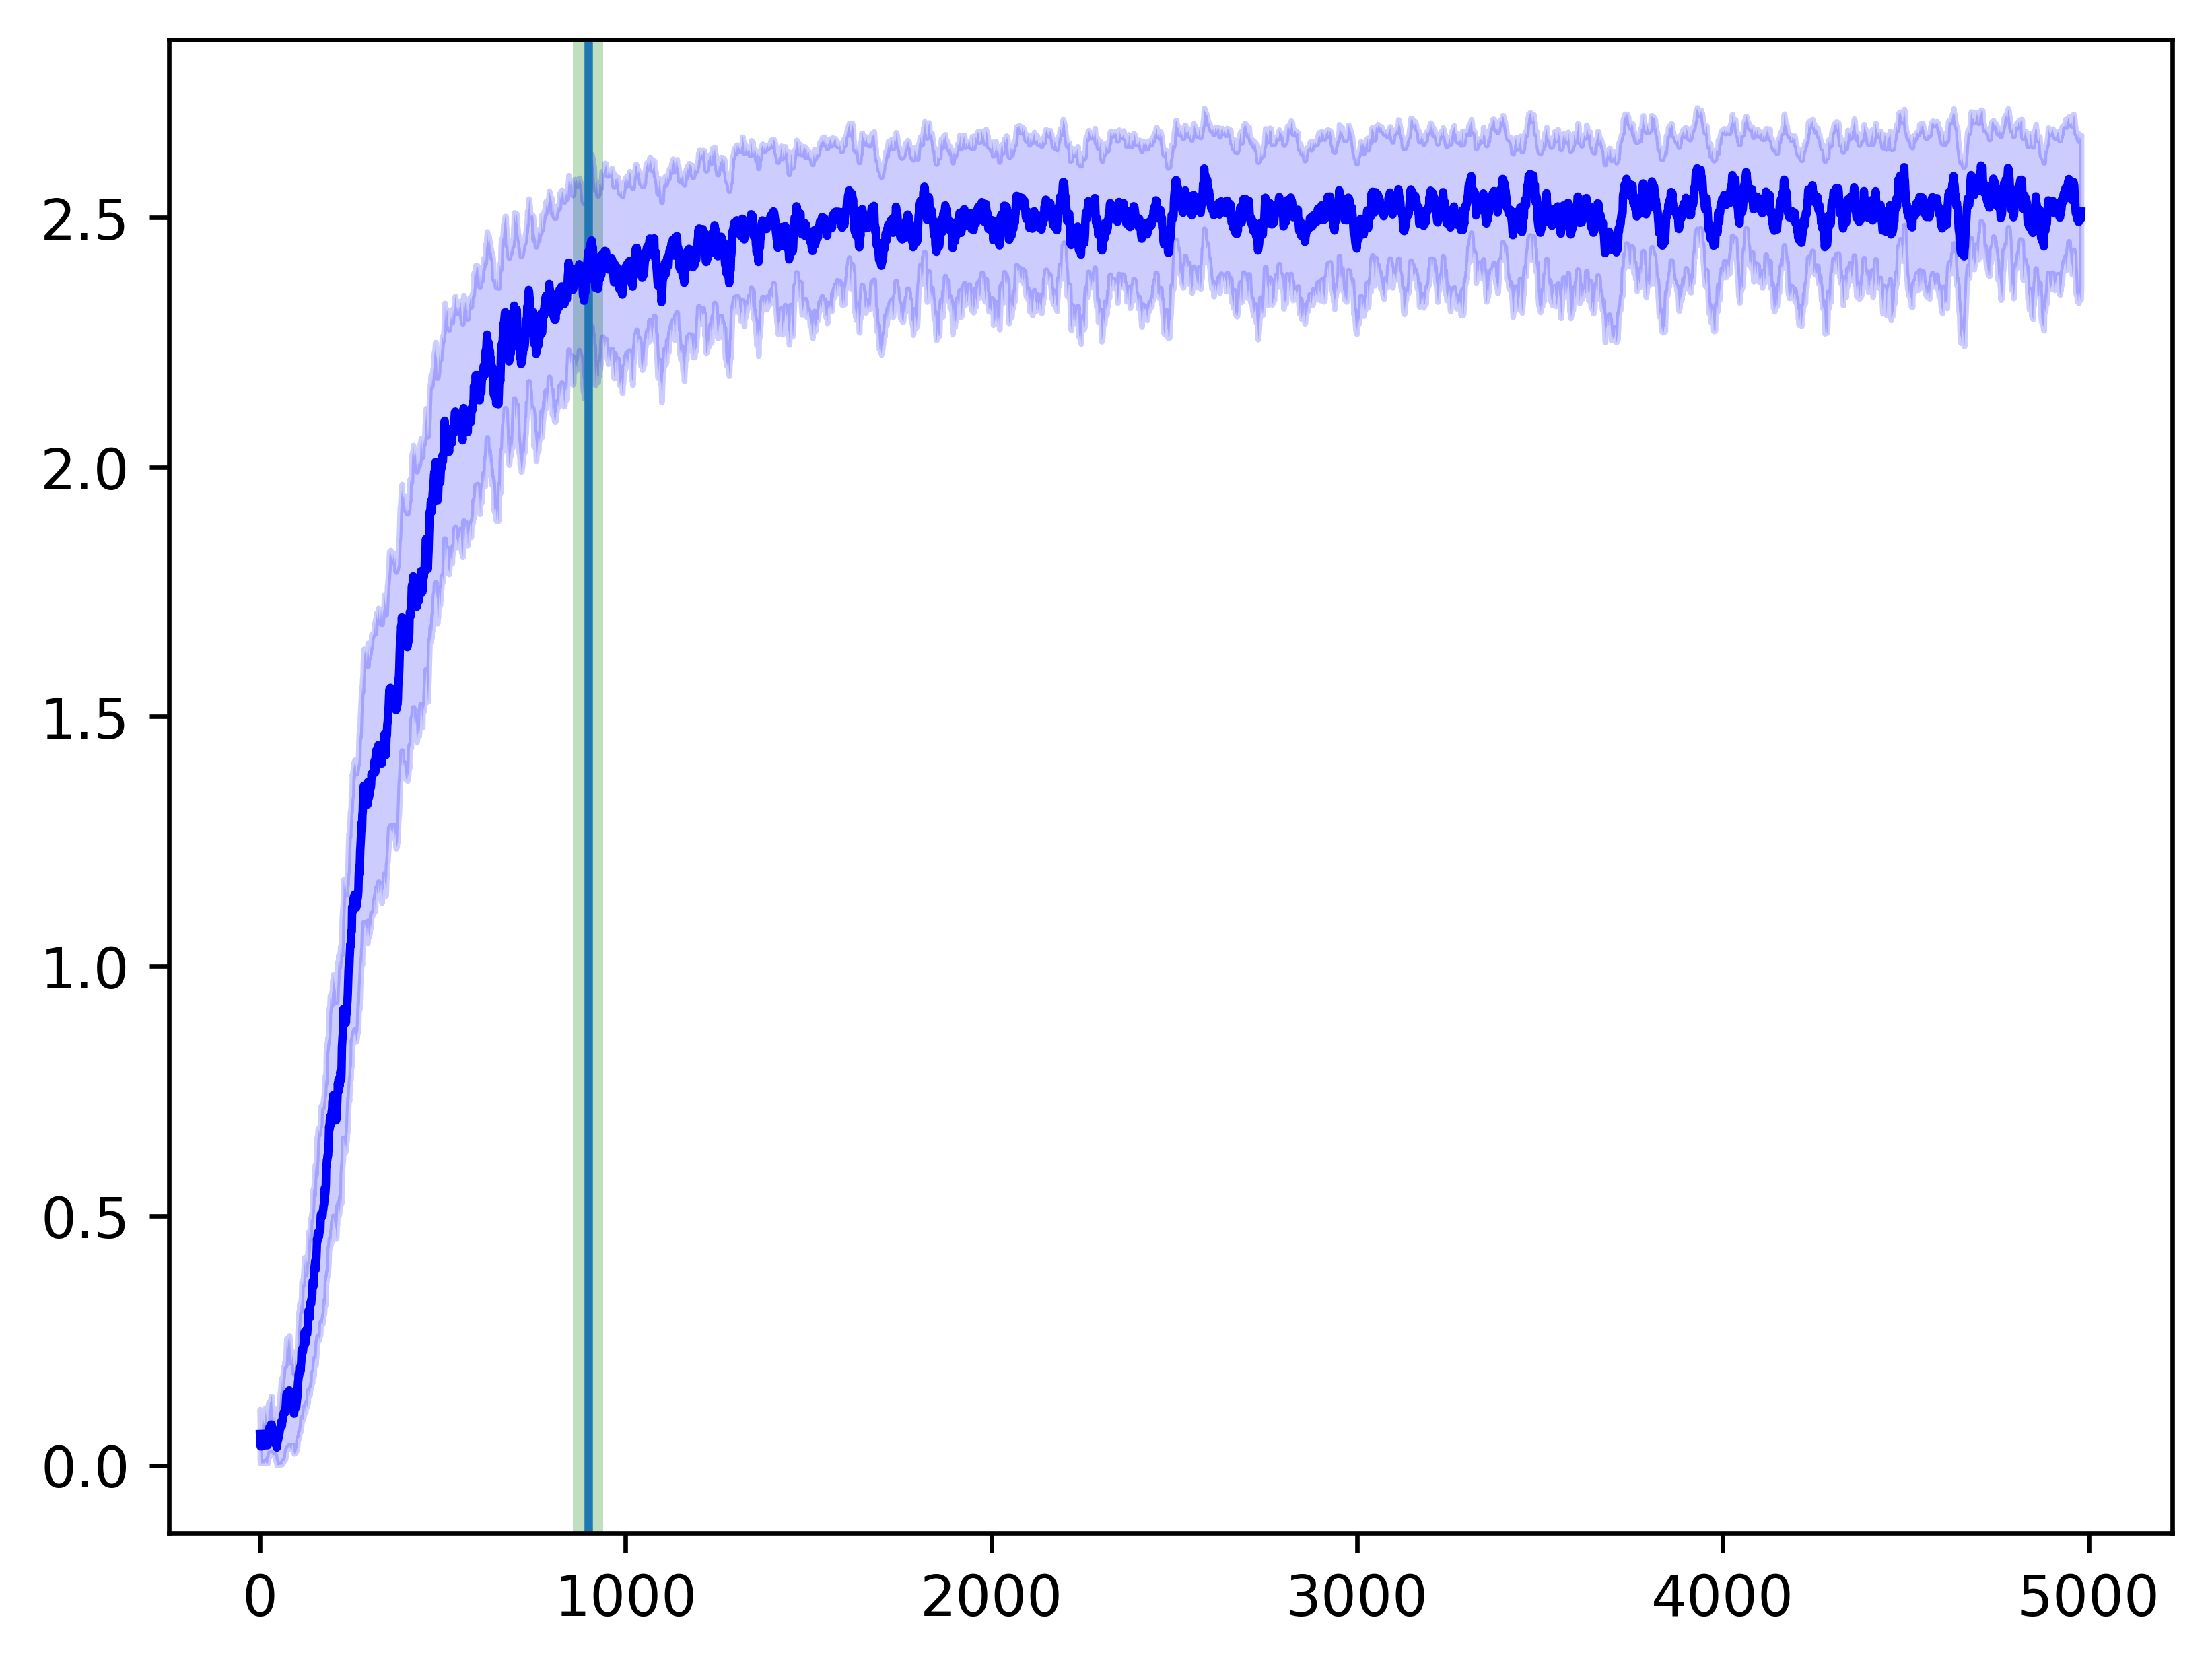

In [83]:
# Variables a guardar para reward plot
d = reward_data['SEC']
l = ltm_data['SEC']

plt.axvline(x=l['mean'])
plt.axvspan(l['min_val'], l['max_val'], facecolor='g', alpha=0.25)

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

# Steps - single

In [74]:
# Variables a computar para reward plot
window_width = 20
data_steps = data['SEC']['real_steps_ts']
data_steps = np.asarray(data_steps, dtype=np.float32)

mean = np.mean(data_steps, axis=0)
yerr = np.std(data_steps, axis=0) / math.sqrt(len(data_steps))

data_steps_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
data_steps_mavecr = (data_steps_cumsum[window_width:] - data_steps_cumsum[:-window_width]) / window_width

data_steps_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
data_steps_mavecr_std = (data_steps_cumsum_std[window_width:] - data_steps_cumsum_std[:-window_width]) / window_width

min_val = data_steps_mavecr - data_steps_mavecr_std
max_val = data_steps_mavecr + data_steps_mavecr_std
length = data_steps_mavecr_std.shape[0]

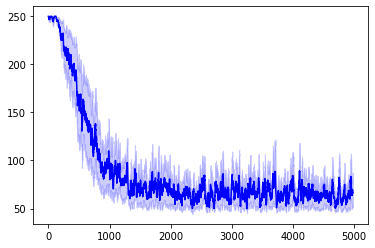

In [75]:
# Variables a guardar para reward plot
plt.plot(data_steps_mavecr, label="Reactive", color='blue')
plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

# Steps - all

In [262]:
steps_data = {}
window_width = 20

for model in models:
    #steps_data["cl"+str(clr)+"_stm"+str(stm)+"_ep1000_dac"] = get_condition_dac("C"+str(clr), "STM"+str(stm), "EP1000", "dac")

    #data_trusteps = cl4_stm50_ep1000_dac['abs_tru_steps']
    data_trusteps = data[model]['real_steps_ts']
    data_trusteps = np.asarray(data_trusteps, dtype=np.float32)
    print("data_trusteps_sum ", np.sum(data_trusteps))
    if np.sum(data_trusteps) > 0:
        if len(data_trusteps[0]) > 5000: 
            data_half = np.hsplit(data_trusteps, 2)
            data_trusteps = data_half[0]

        mean = np.mean(data_trusteps, axis=0)
        yerr = np.std(data_trusteps, axis=0) / math.sqrt(len(data_trusteps))

        data_trusteps_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
        data_trusteps_mavecr = (data_trusteps_cumsum[window_width:] - data_trusteps_cumsum[:-window_width]) / window_width

        data_trusteps_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
        data_trusteps_mavecr_std = (data_trusteps_cumsum_std[window_width:] - data_trusteps_cumsum_std[:-window_width]) / window_width

        steps = {}
        steps['mavecr'] = data_trusteps_mavecr
        steps['mavecr_std'] = data_trusteps_mavecr_std
        steps['min_val'] = data_trusteps_mavecr - data_trusteps_mavecr_std
        steps['max_val'] = data_trusteps_mavecr + data_trusteps_mavecr_std
        steps['length'] = data_trusteps_mavecr_std.shape[0]

        steps_data[model] = steps

save_plot_data(steps_data, 'steps', file_path)

data_trusteps_sum  18081946.0
data_trusteps_sum  9701496.0
data_trusteps_sum  0.0
data_trusteps_sum  0.0
data_trusteps_sum  19689028.0
data_trusteps_sum  19299272.0
data_trusteps_sum  17097920.0
data_trusteps_sum  7909077.0
data_trusteps_sum  10723230.0
data_trusteps_sum  6935377.0
data_trusteps_sum  6935377.0
data_trusteps_sum  8514754.0


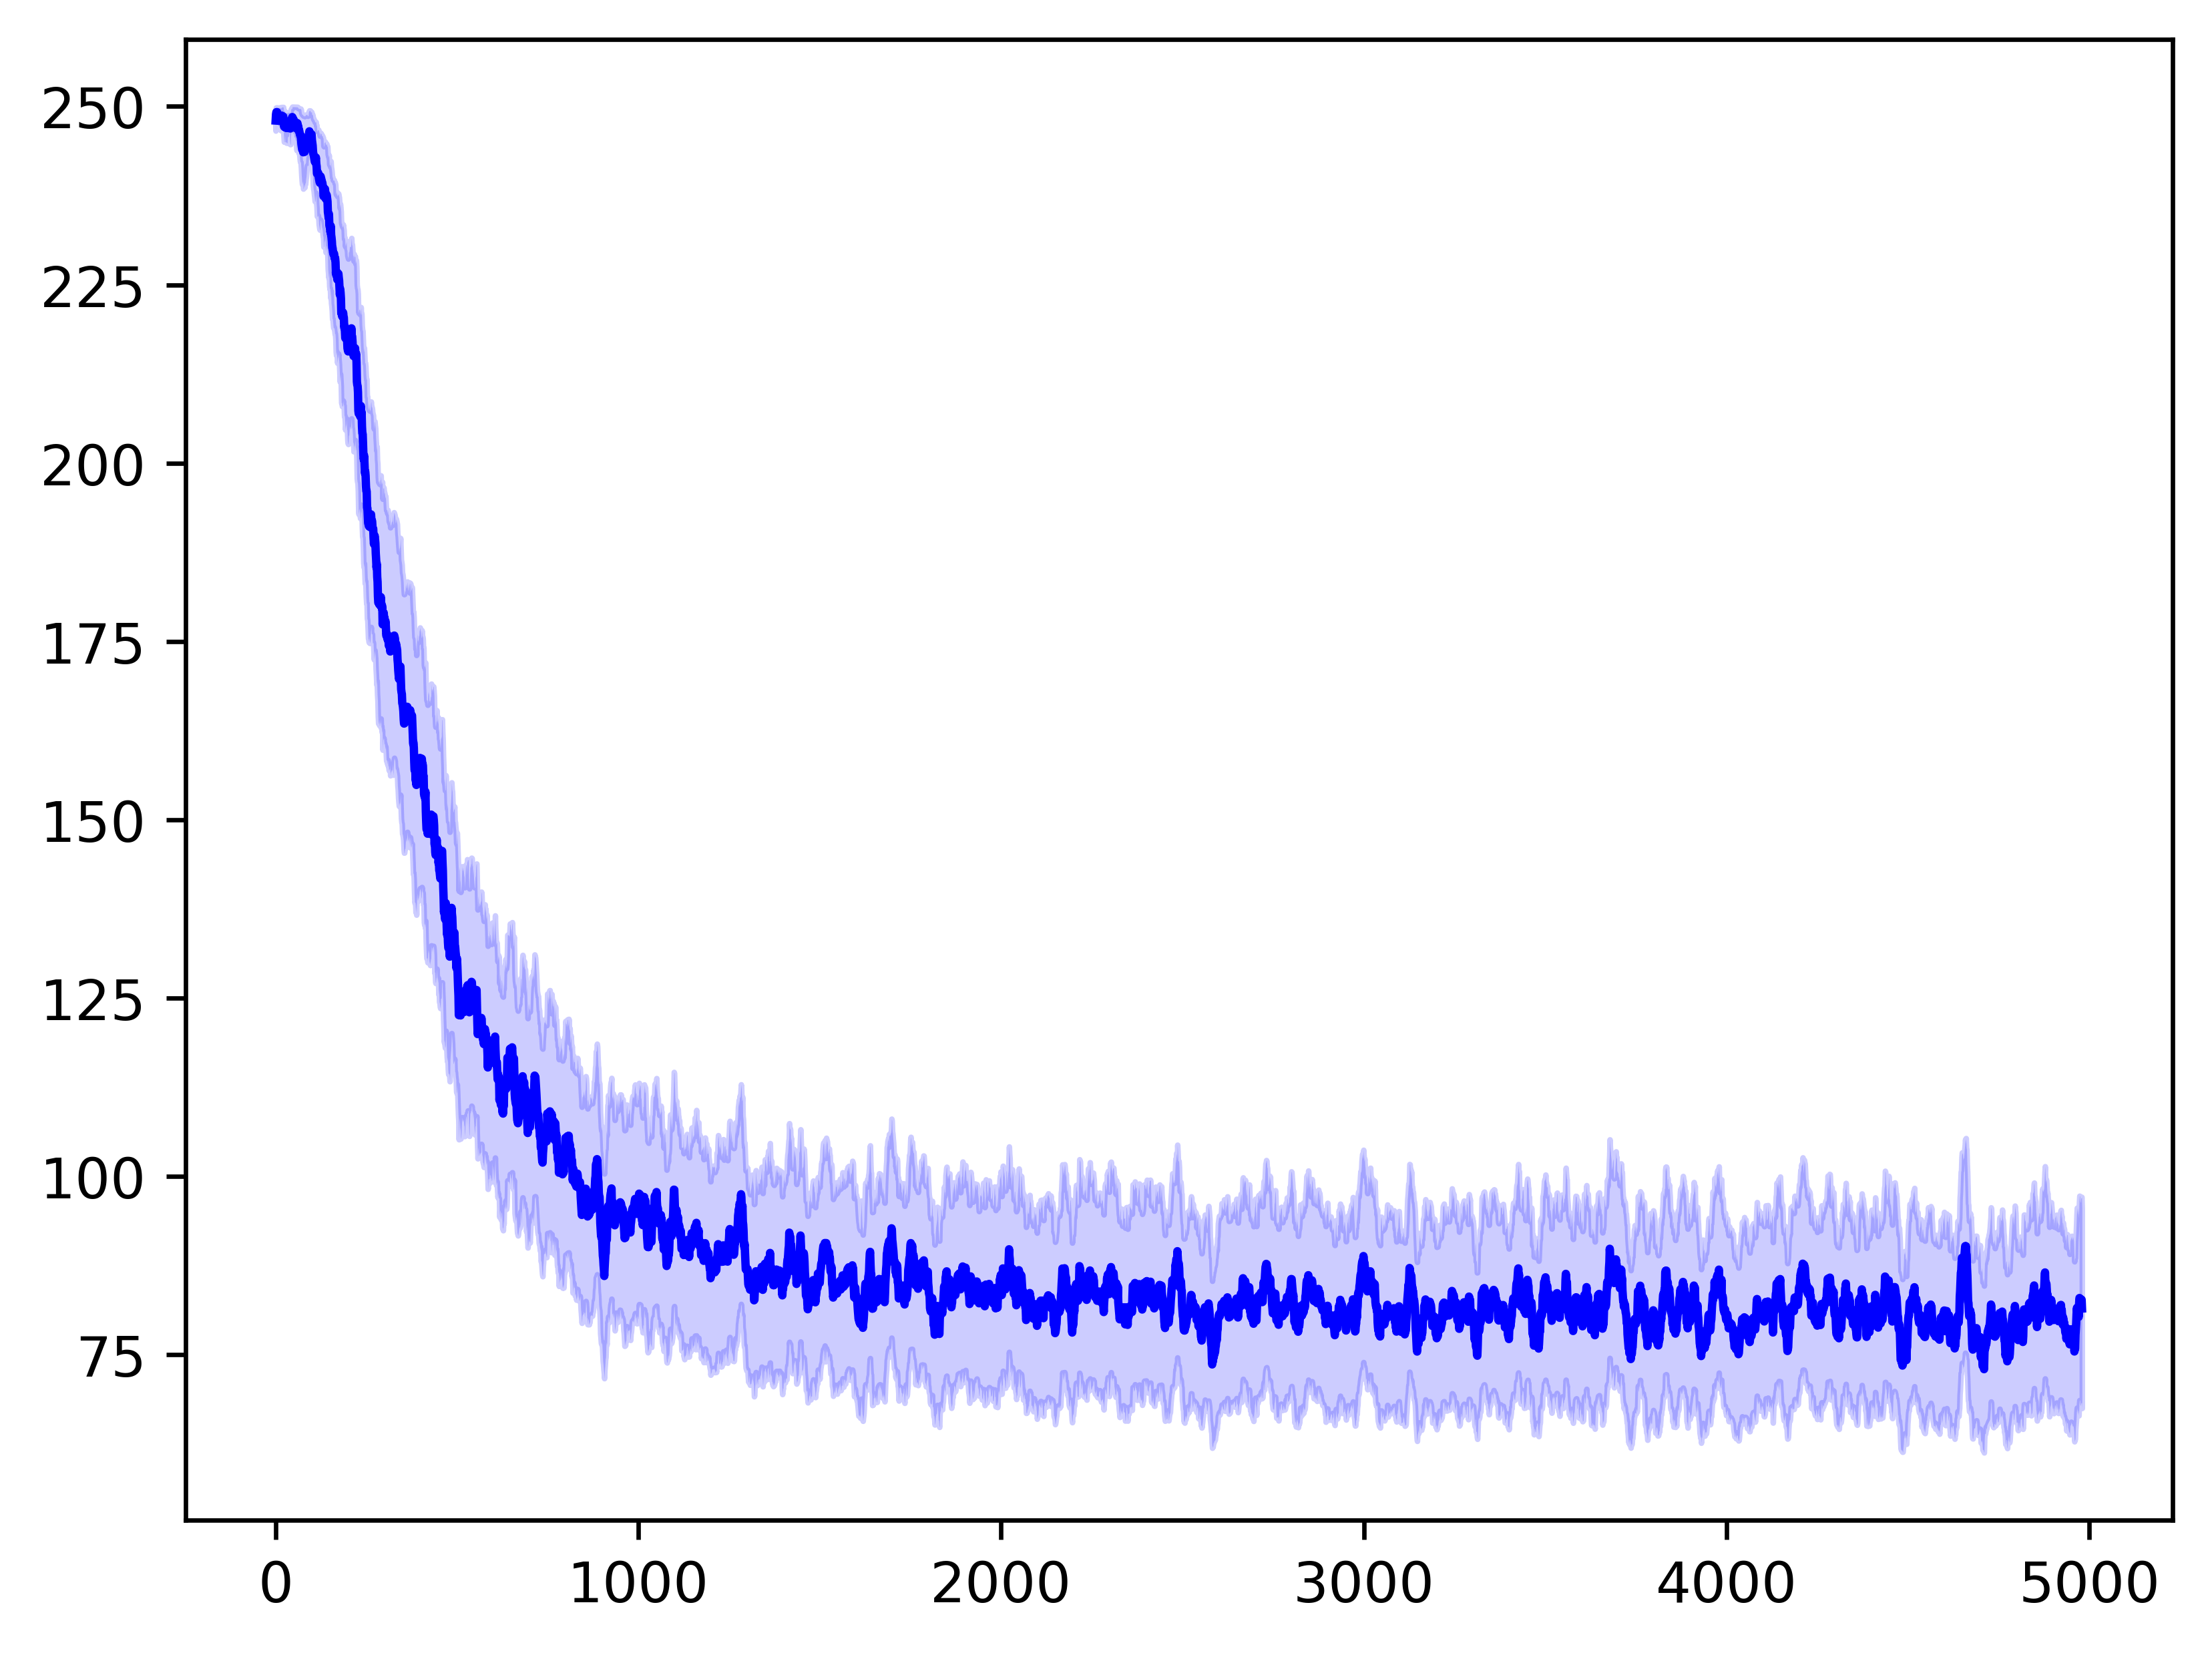

In [263]:
# Variables a guardar para reward plot
d = steps_data['SEC']

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

# Steps normalized - all

In [264]:
stepsnorm_data = {}
window_width = 20
clr = 4
#models = ['SEC', 'NSEC', 'MFEC']
for model in models:

    data_trusteps = data[model]['real_steps_ts']
    data_trusteps = np.asarray(data_trusteps, dtype=np.float32)
    data_trusteps = data_trusteps * clr   
    print("data_trusteps_sum ", np.sum(data_trusteps))
    if np.sum(data_trusteps) > 0:   
        if len(data_trusteps[0]) > 5000: 
            data_half = np.hsplit(data_trusteps, 2)
            data_trusteps = data_half[0]

        mean = np.mean(data_trusteps, axis=0)
        yerr = np.std(data_trusteps, axis=0) / math.sqrt(len(data_trusteps))

        data_trusteps_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
        data_trusteps_mavecr = (data_trusteps_cumsum[window_width:] - data_trusteps_cumsum[:-window_width]) / window_width

        data_trusteps_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
        data_trusteps_mavecr_std = (data_trusteps_cumsum_std[window_width:] - data_trusteps_cumsum_std[:-window_width]) / window_width

        steps = {}
        steps['mavecr'] = data_trusteps_mavecr
        steps['mavecr_std'] = data_trusteps_mavecr_std
        steps['min_val'] = data_trusteps_mavecr - data_trusteps_mavecr_std
        steps['max_val'] = data_trusteps_mavecr + data_trusteps_mavecr_std
        steps['length'] = data_trusteps_mavecr_std.shape[0]

        stepsnorm_data[model] = steps

save_plot_data(stepsnorm_data, 'stepsnorm', file_path)

data_trusteps_sum  72327784.0
data_trusteps_sum  38805984.0
data_trusteps_sum  0.0
data_trusteps_sum  0.0
data_trusteps_sum  78756110.0
data_trusteps_sum  77197090.0
data_trusteps_sum  68391680.0
data_trusteps_sum  31636308.0
data_trusteps_sum  42892920.0
data_trusteps_sum  27741508.0
data_trusteps_sum  27741508.0
data_trusteps_sum  34059016.0


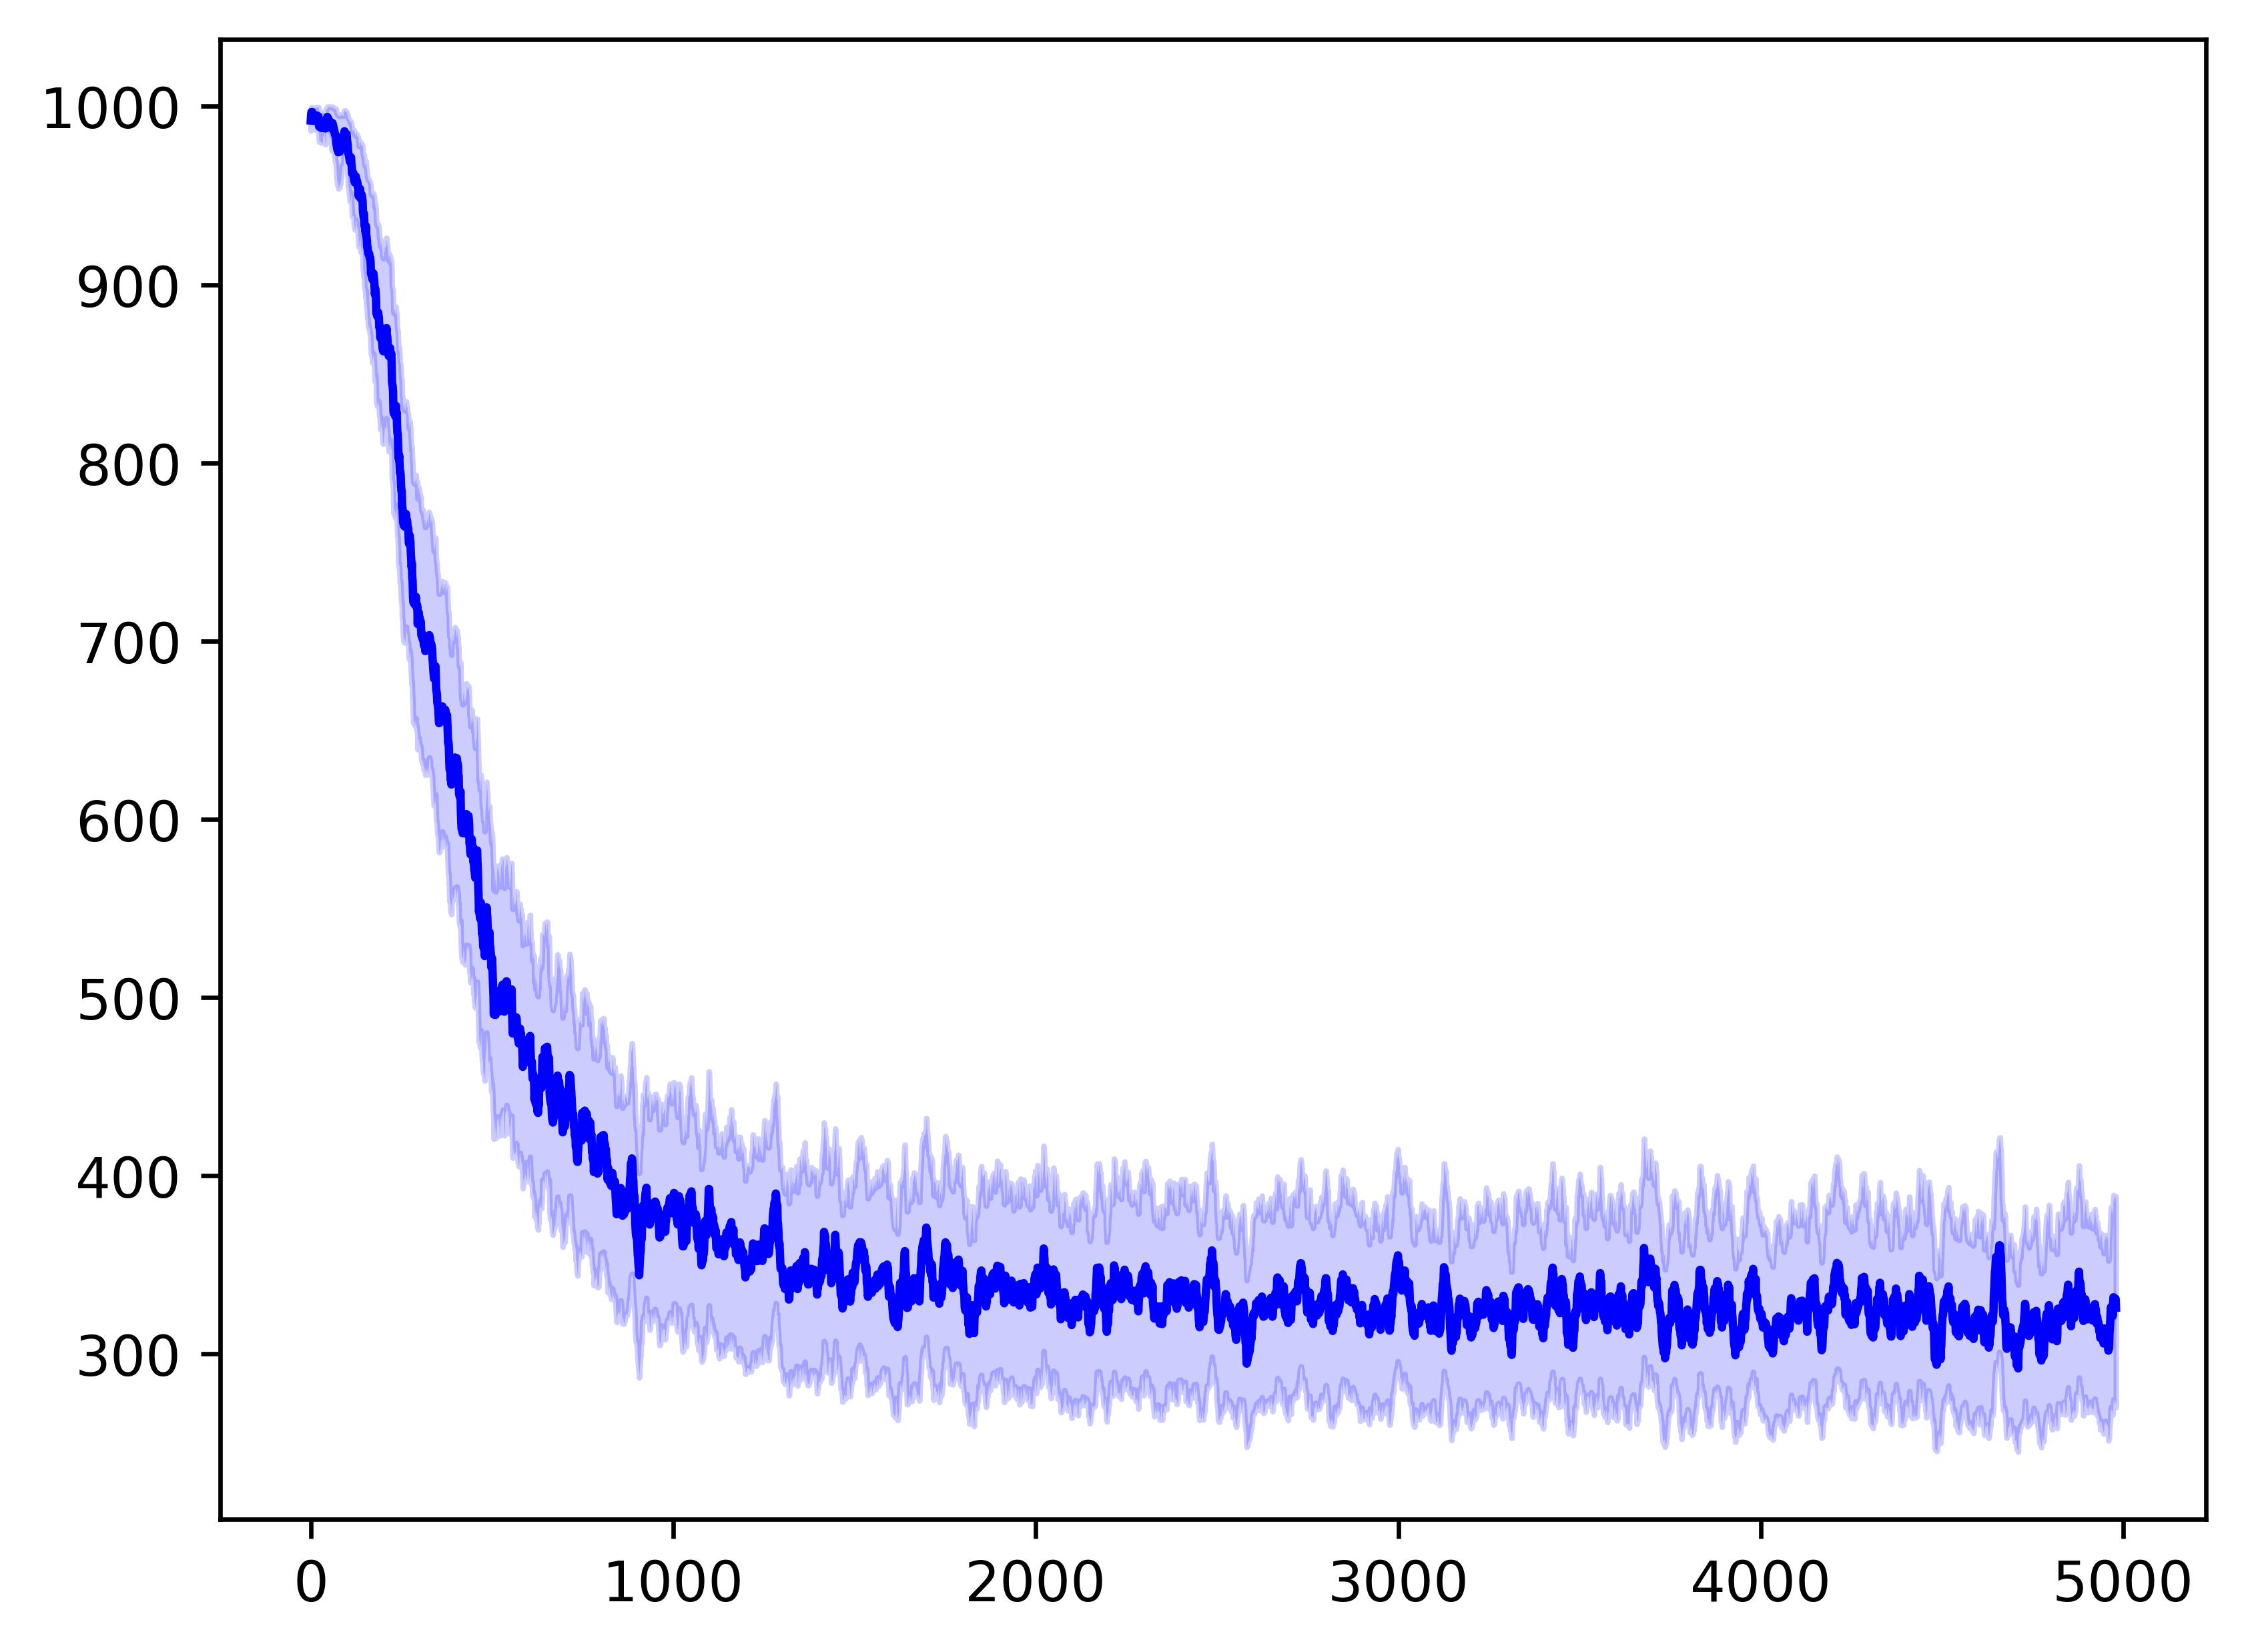

In [265]:
# Variables a guardar para reward plot
d = stepsnorm_data['SEC']

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

# Steps accumulated - single

In [77]:
# Variables a computar para reward plot
window_width = 20
data_steps_acc = data['SEC']['acc_steps_ts']
data_steps_acc = np.asarray(data_steps_acc, dtype=np.float32)

mean = np.mean(data_steps_acc, axis=0)
yerr = np.std(data_steps_acc, axis=0) / math.sqrt(len(data_steps_acc))

data_steps_acc_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
data_steps_acc_mavecr = (data_steps_acc_cumsum[window_width:] - data_steps_acc_cumsum[:-window_width]) / window_width

data_steps_acc_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
data_steps_acc_mavecr_std = (data_steps_acc_cumsum_std[window_width:] - data_steps_acc_cumsum_std[:-window_width]) / window_width

min_val = data_steps_acc_mavecr - data_steps_acc_mavecr_std
max_val = data_steps_acc_mavecr + data_steps_acc_mavecr_std
length = data_steps_acc_mavecr_std.shape[0]


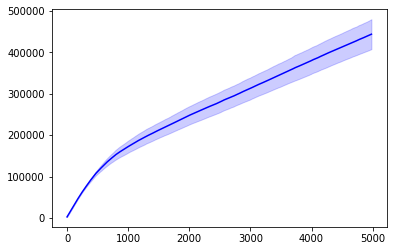

In [78]:
# Variables a guardar para reward plot
plt.plot(data_steps_acc_mavecr, label="Reactive", color='blue')
plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

# Steps accumulated - all

In [266]:
stepsacc_data = {}
window_width = 20

for model in models:

    data_accsteps = data[model]['acc_steps_ts']
    data_accsteps = np.asarray(data_accsteps, dtype=np.float32)
    print("data_accsteps_sum ", np.sum(data_accsteps))

    if np.sum(data_accsteps) > 0:
        if len(data_accsteps[0]) > 5000: 
            data_half = np.hsplit(data_accsteps, 2)
            data_accsteps = data_half[0]

        mean = np.mean(data_accsteps, axis=0)
        yerr = np.std(data_accsteps, axis=0) / math.sqrt(len(data_accsteps))

        data_accsteps_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
        data_accsteps_mavecr = (data_accsteps_cumsum[window_width:] - data_accsteps_cumsum[:-window_width]) / window_width

        data_accsteps_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
        data_accsteps_mavecr_std = (data_accsteps_cumsum_std[window_width:] - data_accsteps_cumsum_std[:-window_width]) / window_width

        totalsteps = []
        for d in data_accsteps: 
            #print(d[-1])
            totalsteps.append(d[-1])

        steps = {}
        steps['total'] = totalsteps
        steps['mavecr'] = data_accsteps_mavecr
        steps['mavecr_std'] = data_accsteps_mavecr_std
        steps['min_val'] = data_accsteps_mavecr - data_accsteps_mavecr_std
        steps['max_val'] = data_accsteps_mavecr + data_accsteps_mavecr_std
        steps['length'] = data_accsteps_mavecr_std.shape[0]

        stepsacc_data[model] = steps

save_plot_data(stepsacc_data, 'stepsacc', file_path)

data_accsteps_sum  47876270000.0
data_accsteps_sum  27634106000.0
data_accsteps_sum  0.0
data_accsteps_sum  0.0
data_accsteps_sum  51608530000.0
data_accsteps_sum  51943080000.0
data_accsteps_sum  47082260000.0
data_accsteps_sum  24282490000.0
data_accsteps_sum  29322904000.0
data_accsteps_sum  19724206000.0
data_accsteps_sum  19724206000.0
data_accsteps_sum  26030432000.0


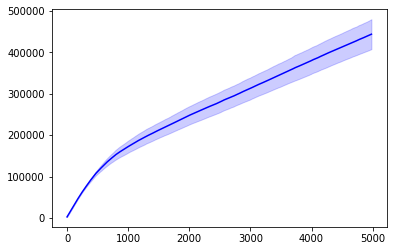

In [94]:
# Variables a guardar para reward plot
d = stepsacc_data['SEC']
plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

# Entropy - single

In [278]:
file_path = '../data/exp4_forgetting/'
model = 'SEC_500_forgetPRIOR'
SEC_500_forgetPRIOR = load_plot_data('SEC_500_forgetPRIOR', file_path)
SEC_500_forgetPRIOR.keys()

dict_keys(['abs_tru_reward', 'acc_tru_reward', 'reward_steps_ts', 'real_steps_ts', 'acc_steps_ts', 'mean_entropy', 'LTM_full', 'reactive_relact', 'contextual_relact', 'reactive_wins', 'contextual_wins', 'abs_rew_reactive', 'abs_rew_contextual', 'acc_rew_reactive', 'acc_rew_contextual', 'steps_reactive', 'steps_contextual'])

In [279]:
# Variables a computar para reward plot

window_width = 20
data_truentropy = SEC_500_forgetPRIOR['mean_entropy']
data_truentropy = np.asarray(data_truentropy, dtype=np.float32)

mean = np.mean(data_truentropy, axis=0)
yerr = np.std(data_truentropy, axis=0) / math.sqrt(len(data_truentropy))

data_truentropy_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
data_truentropy_mavecr = (data_truentropy_cumsum[window_width:] - data_truentropy_cumsum[:-window_width]) / window_width

data_truentropy_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
data_truentropy_mavecr_std = (data_truentropy_cumsum_std[window_width:] - data_truentropy_cumsum_std[:-window_width]) / window_width

min_val = data_truentropy_mavecr - data_truentropy_mavecr_std
max_val = data_truentropy_mavecr + data_truentropy_mavecr_std
length = data_truentropy_mavecr_std.shape[0]

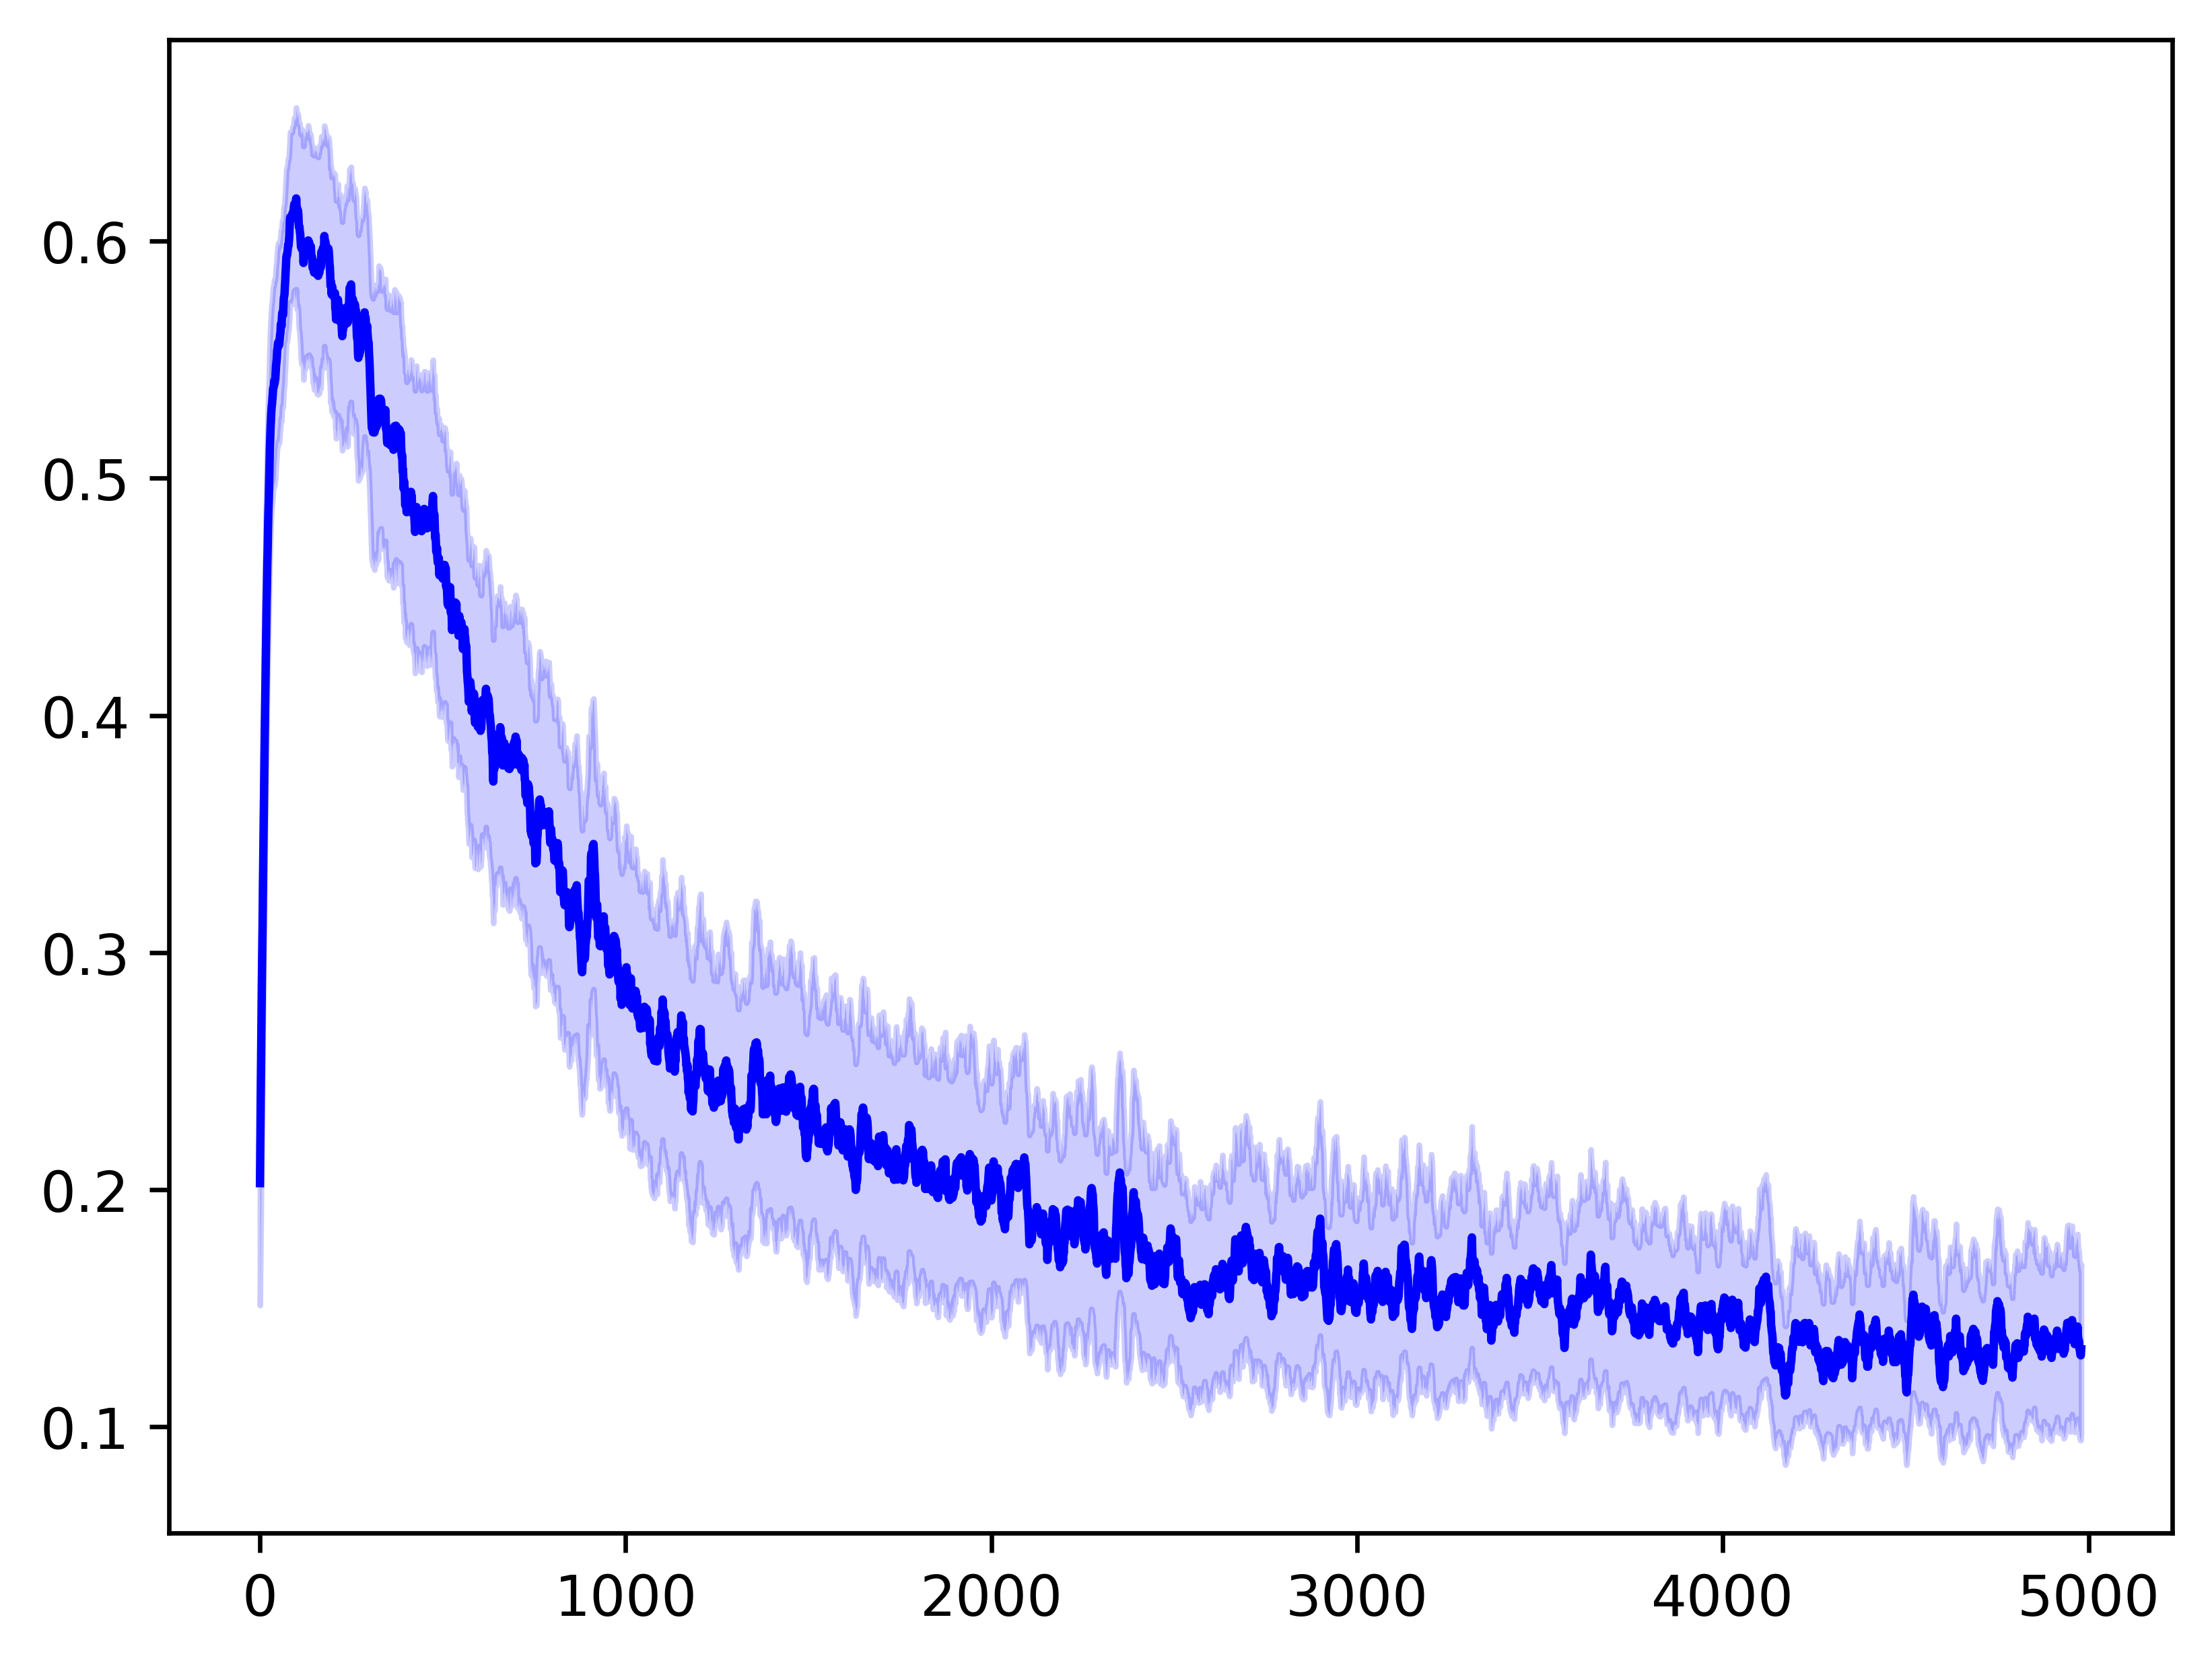

In [281]:
# Variables a guardar para reward plot
plt.plot(data_truentropy_mavecr, label="Reactive", color='blue')
plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

In [282]:
SEC_500_forgetPRIOR_entropy = {}

SEC_500_forgetPRIOR_entropy['mavecr'] = data_truentropy_mavecr
SEC_500_forgetPRIOR_entropy['mavecr_std'] = data_truentropy_mavecr_std
SEC_500_forgetPRIOR_entropy['min_val'] = min_val
SEC_500_forgetPRIOR_entropy['max_val'] = max_val
SEC_500_forgetPRIOR_entropy['length'] = length

#entropy_data[model] = entropy

In [283]:
file_path = '../data/exp4_forgetting/'
entropy_data = load_plot_data('entropy_new',file_path)
entropy_data.keys()

dict_keys(['SEC', 'NSEC', 'NSEC-FIFO', 'NSEC-RWD', 'SEC-FIFO_v2', 'SEC-RWD_v2', 'SEC-RWD_v3'])

In [284]:
entropy_data['SEC-PRIOR'] = SEC_500_forgetPRIOR_entropy

In [286]:
entropy_data['SEC'].keys()

dict_keys(['mavecr', 'mavecr_std', 'min_val', 'max_val', 'length'])

In [287]:
entropy_data['SEC-PRIOR'].keys()

dict_keys(['mavecr', 'mavecr_std', 'min_val', 'max_val', 'length'])

In [288]:
save_plot_data(entropy_data, 'entropy_new', file_path)

In [272]:
file_path = '../data/exp4_forgetting/'
data = load_plot_data('data_new',file_path)

In [273]:
data_truentropy = data['SEC-PRIOR']['mean_entropy']
data_truentropy[0]

[0.0,
 0.004195195654769769,
 0.552682168509484,
 0.5231681828774961,
 0.4769040327602082,
 0.45402280504693215,
 0.372784452425006,
 0.46820855441981923,
 0.5067925538881256,
 0.42509931454367395,
 0.4273381501841675,
 0.4508765658854288,
 0.6162248163411678,
 0.4339303846776346,
 0.4038106303792435,
 0.43237471467519545,
 0.44966486450115756,
 0.3795734368433477,
 0.4749266660885864,
 0.46344390579739775,
 0.4923229585746704,
 0.29103613768959674,
 0.5195270192139461,
 0.43128744476174463,
 0.50898123319735,
 0.3754335074607498,
 0.4835851336642789,
 0.5105925897906722,
 0.4034401587630983,
 0.46911540892007164,
 0.42944068581984607,
 0.39329479624504243,
 0.3782925104373141,
 0.423069804368321,
 0.4645793382339944,
 0.27397608151579245,
 0.4724785655331797,
 0.521891067978964,
 0.44222317044138876,
 0.5100439968529097,
 0.45010820856373696,
 0.4425222594059056,
 0.4085383613903168,
 0.45232945603580743,
 0.625003521413716,
 0.23024125592097713,
 0.4539085434036055,
 0.53296918247705

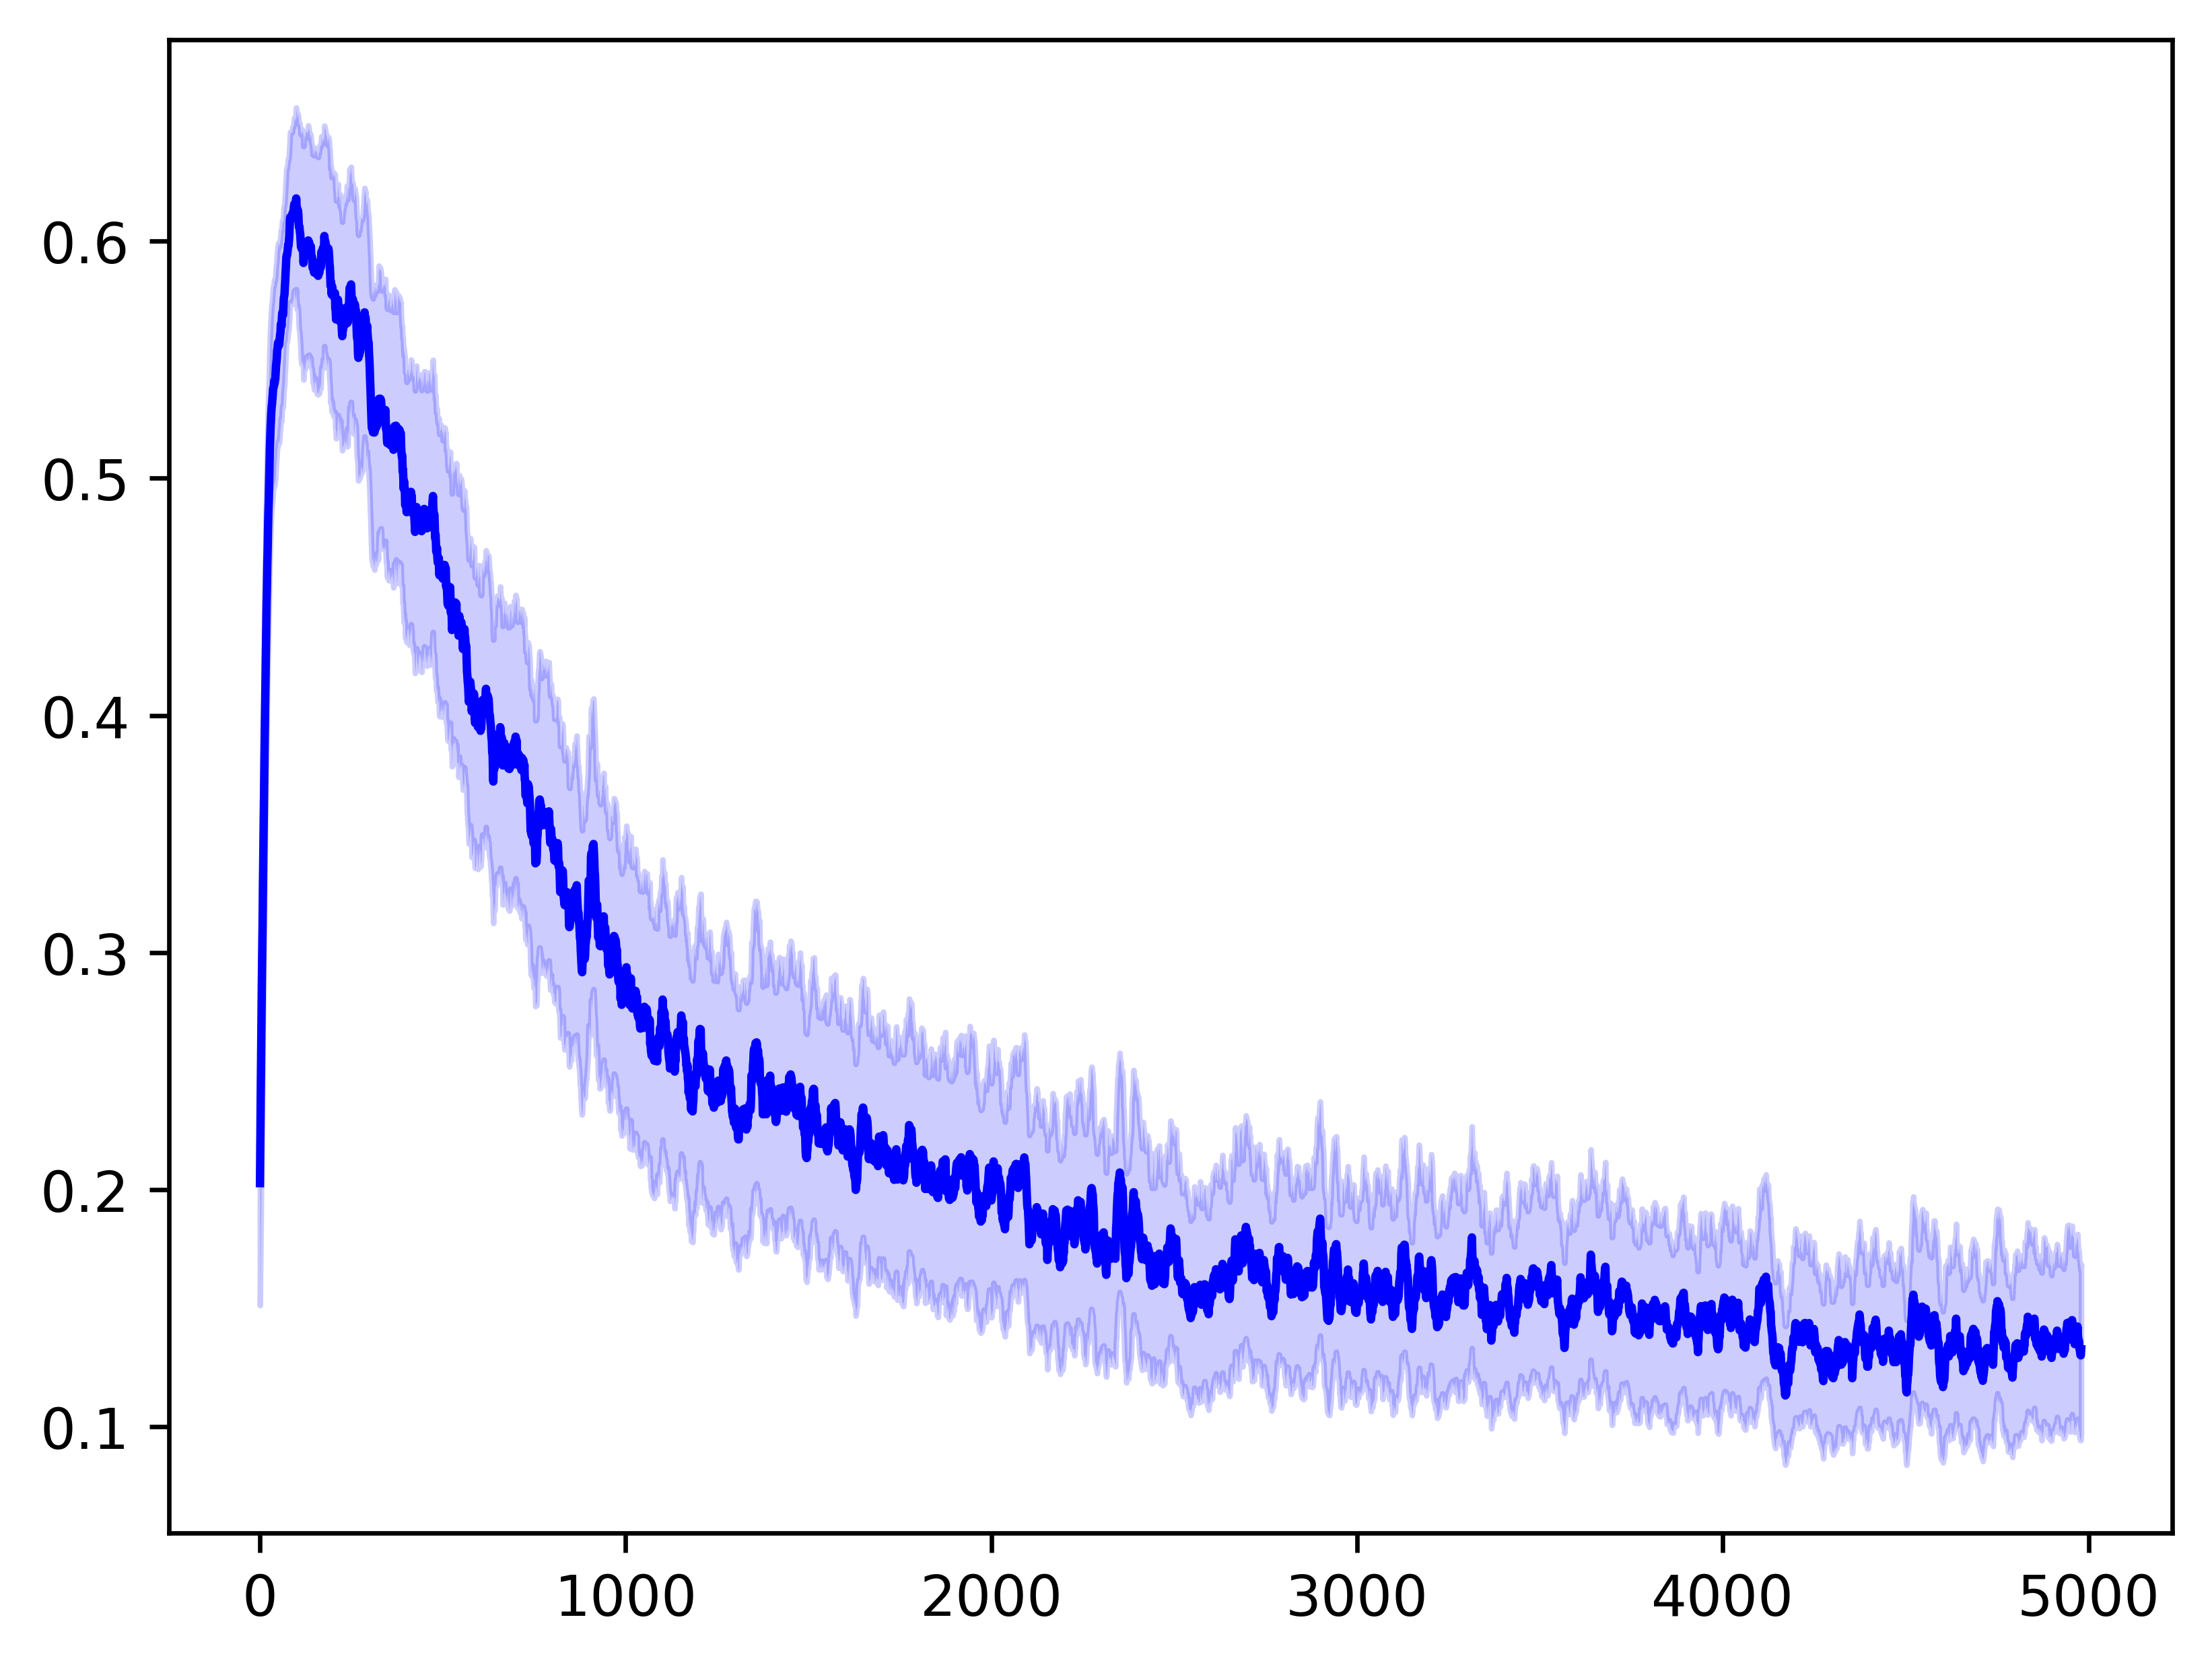

In [274]:
# Variables a guardar para reward plot
plt.plot(data_truentropy_mavecr, label="Reactive", color='blue')
plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

# Entropy - all

In [203]:
#models = ['SEC', 'NSEC', 'NSEC-FIFO', 'NSEC-RWD', 'SEC-FIFO_v2', 'SEC-RWD_v2', 'SEC-RWD_v3']

In [267]:
entropy_data = {}
window_width = 20


for model in models:
    #entropy_data["cl"+str(clr)+"_stm"+str(stm)+"_ep1000_dac"] = get_condition_dac("C"+str(clr), "STM"+str(stm), "EP1000", "dac")

    #data_truentropy = cl4_stm50_ep1000_dac['abs_tru_entropy']
    data_truentropy = data[model]['mean_entropy']
    data_truentropy = np.asarray(data_truentropy, dtype=np.float32)
    print("data_truentropy_sum ", np.sum(data_truentropy))
    #if np.sum(data_truentropy) > 0:                       
    if len(data_truentropy[0]) > 5000: 
        data_half = np.hsplit(data_truentropy, 2)
        data_truentropy = data_half[0]

    mean = np.mean(data_truentropy, axis=0)
    yerr = np.std(data_truentropy, axis=0) / math.sqrt(len(data_truentropy))

    data_truentropy_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
    data_truentropy_mavecr = (data_truentropy_cumsum[window_width:] - data_truentropy_cumsum[:-window_width]) / window_width

    data_truentropy_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
    data_truentropy_mavecr_std = (data_truentropy_cumsum_std[window_width:] - data_truentropy_cumsum_std[:-window_width]) / window_width

    entropy = {}
    entropy['mavecr'] = data_truentropy_mavecr
    entropy['mavecr_std'] = data_truentropy_mavecr_std
    entropy['min_val'] = data_truentropy_mavecr - data_truentropy_mavecr_std
    entropy['max_val'] = data_truentropy_mavecr + data_truentropy_mavecr_std
    entropy['length'] = data_truentropy_mavecr_std.shape[0]

    entropy_data[model] = entropy

save_plot_data(entropy_data, 'entropy_new', file_path)

data_truentropy_sum  0.0
data_truentropy_sum  25618.91
data_truentropy_sum  0.0


IndexError: index 0 is out of bounds for axis 0 with size 0

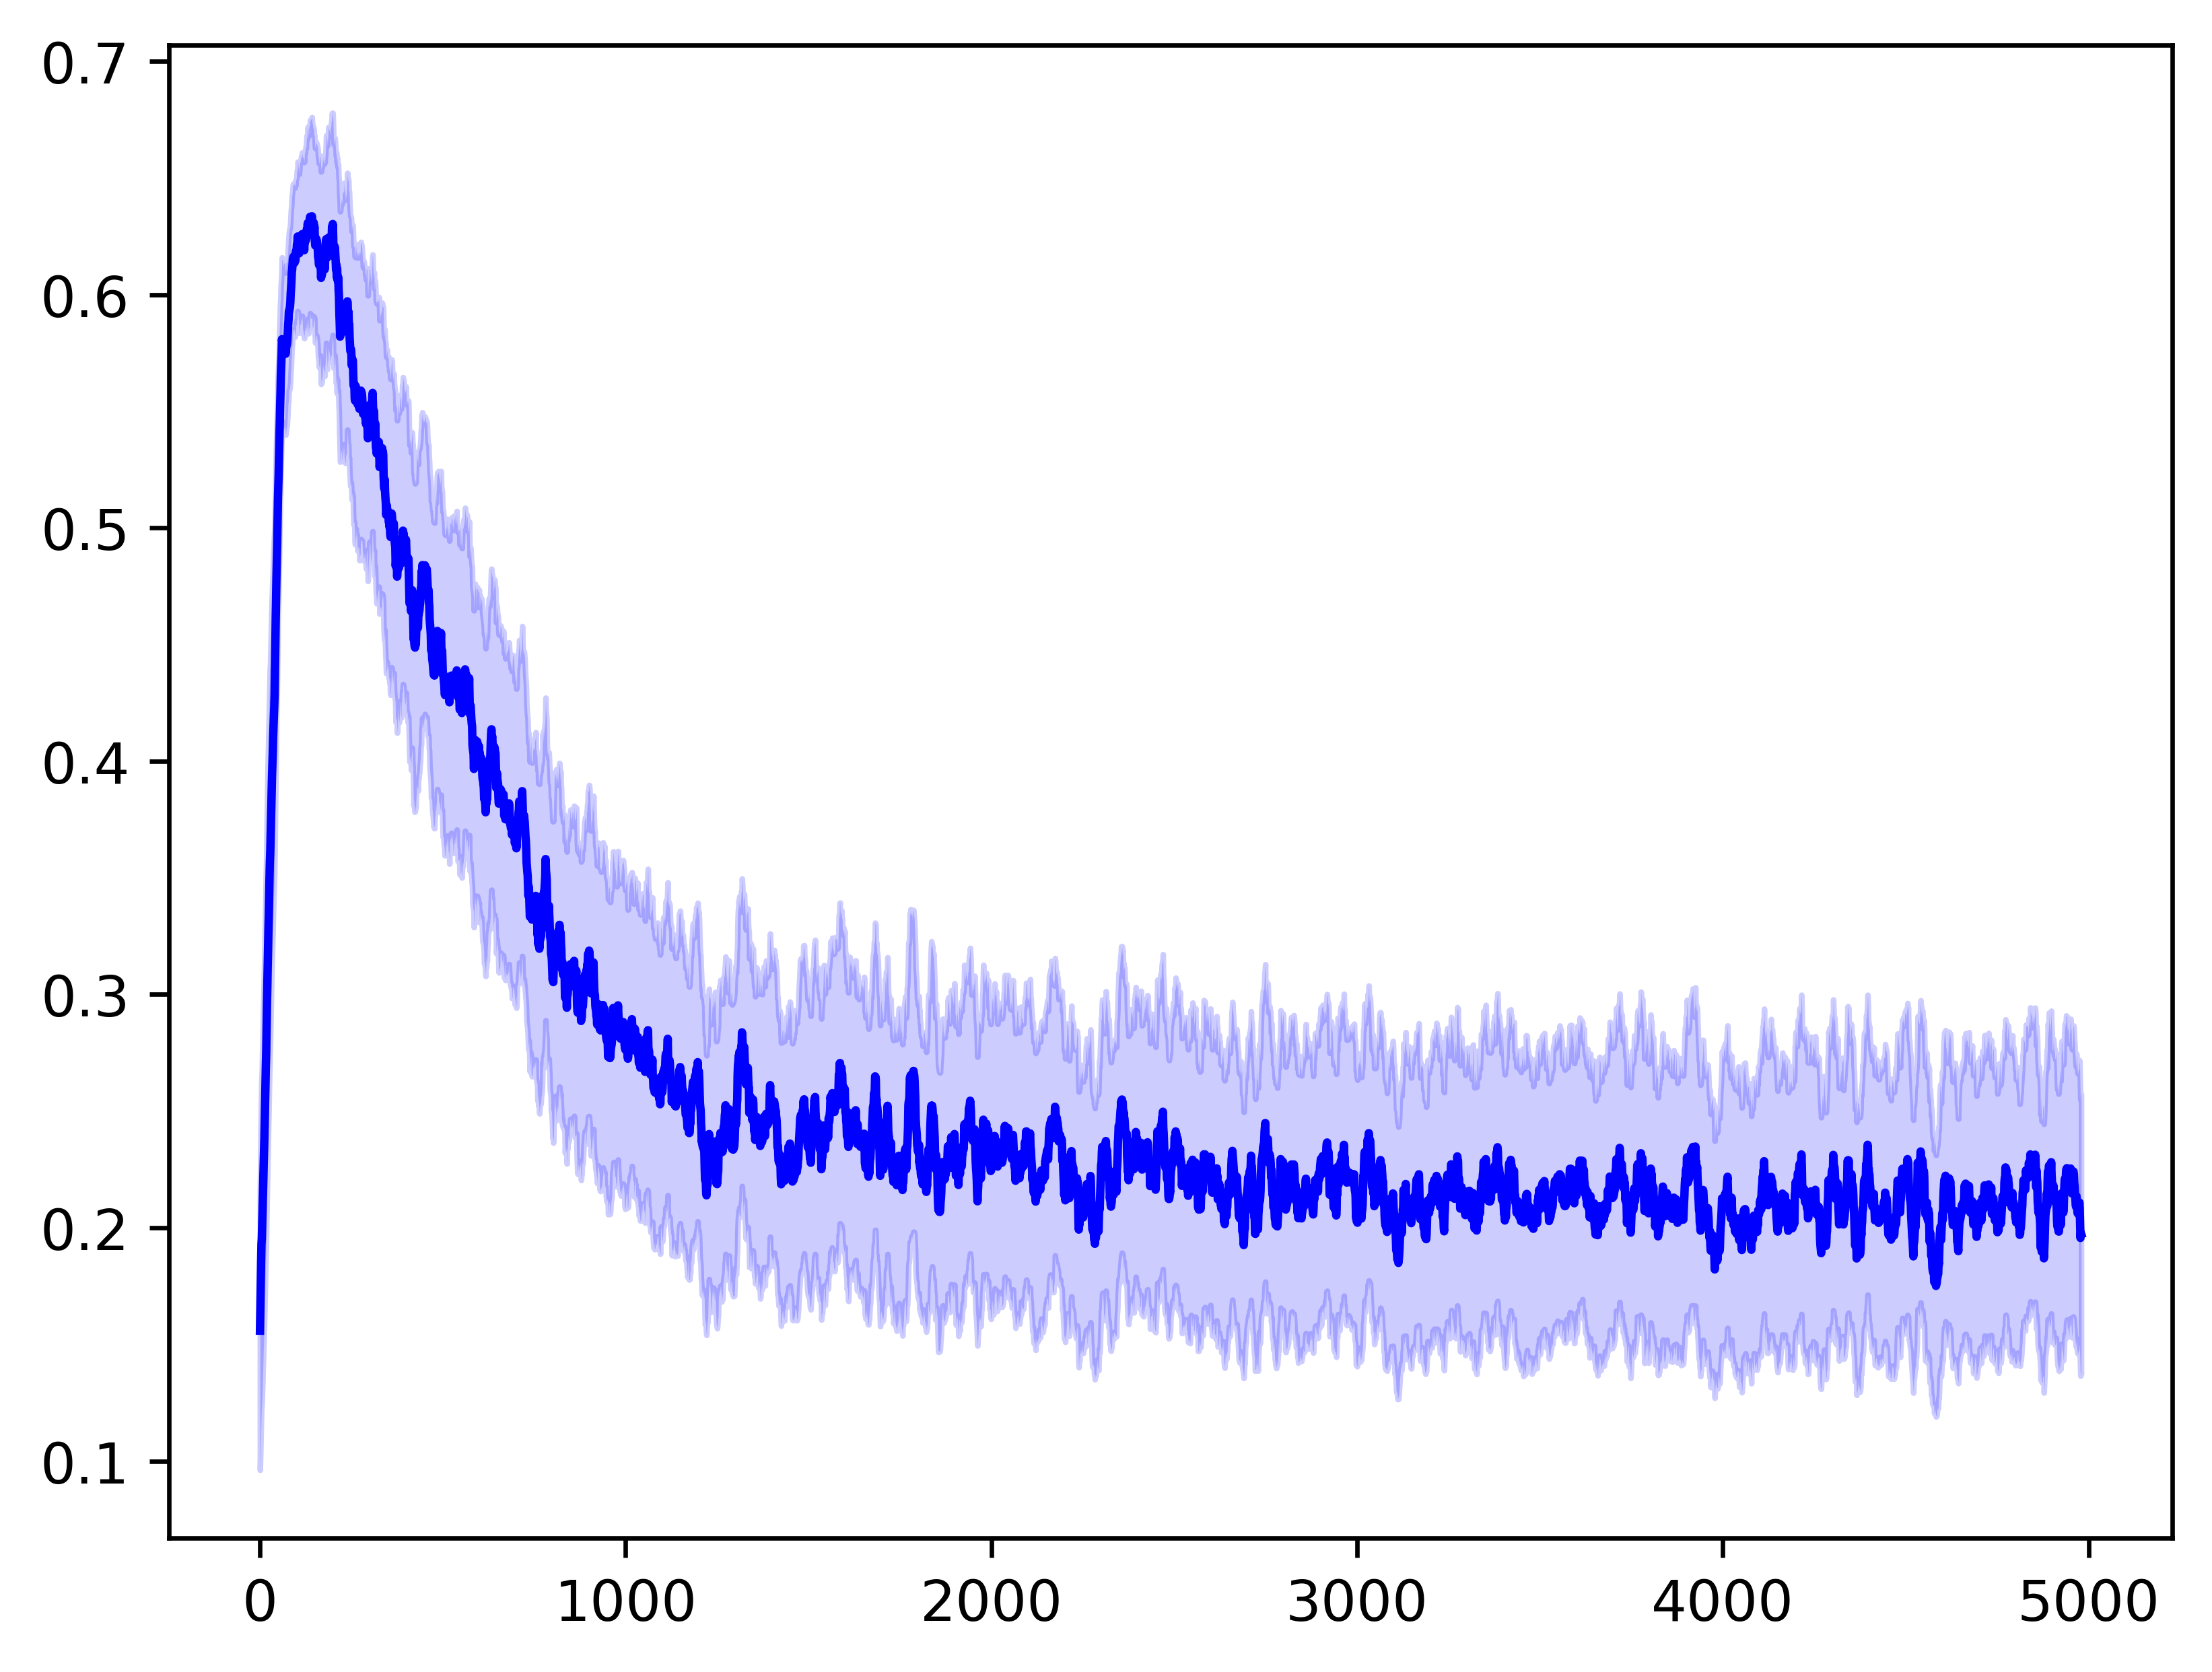

In [237]:
# Variables a guardar para entropy plot
d = entropy_data['noGi_new']

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

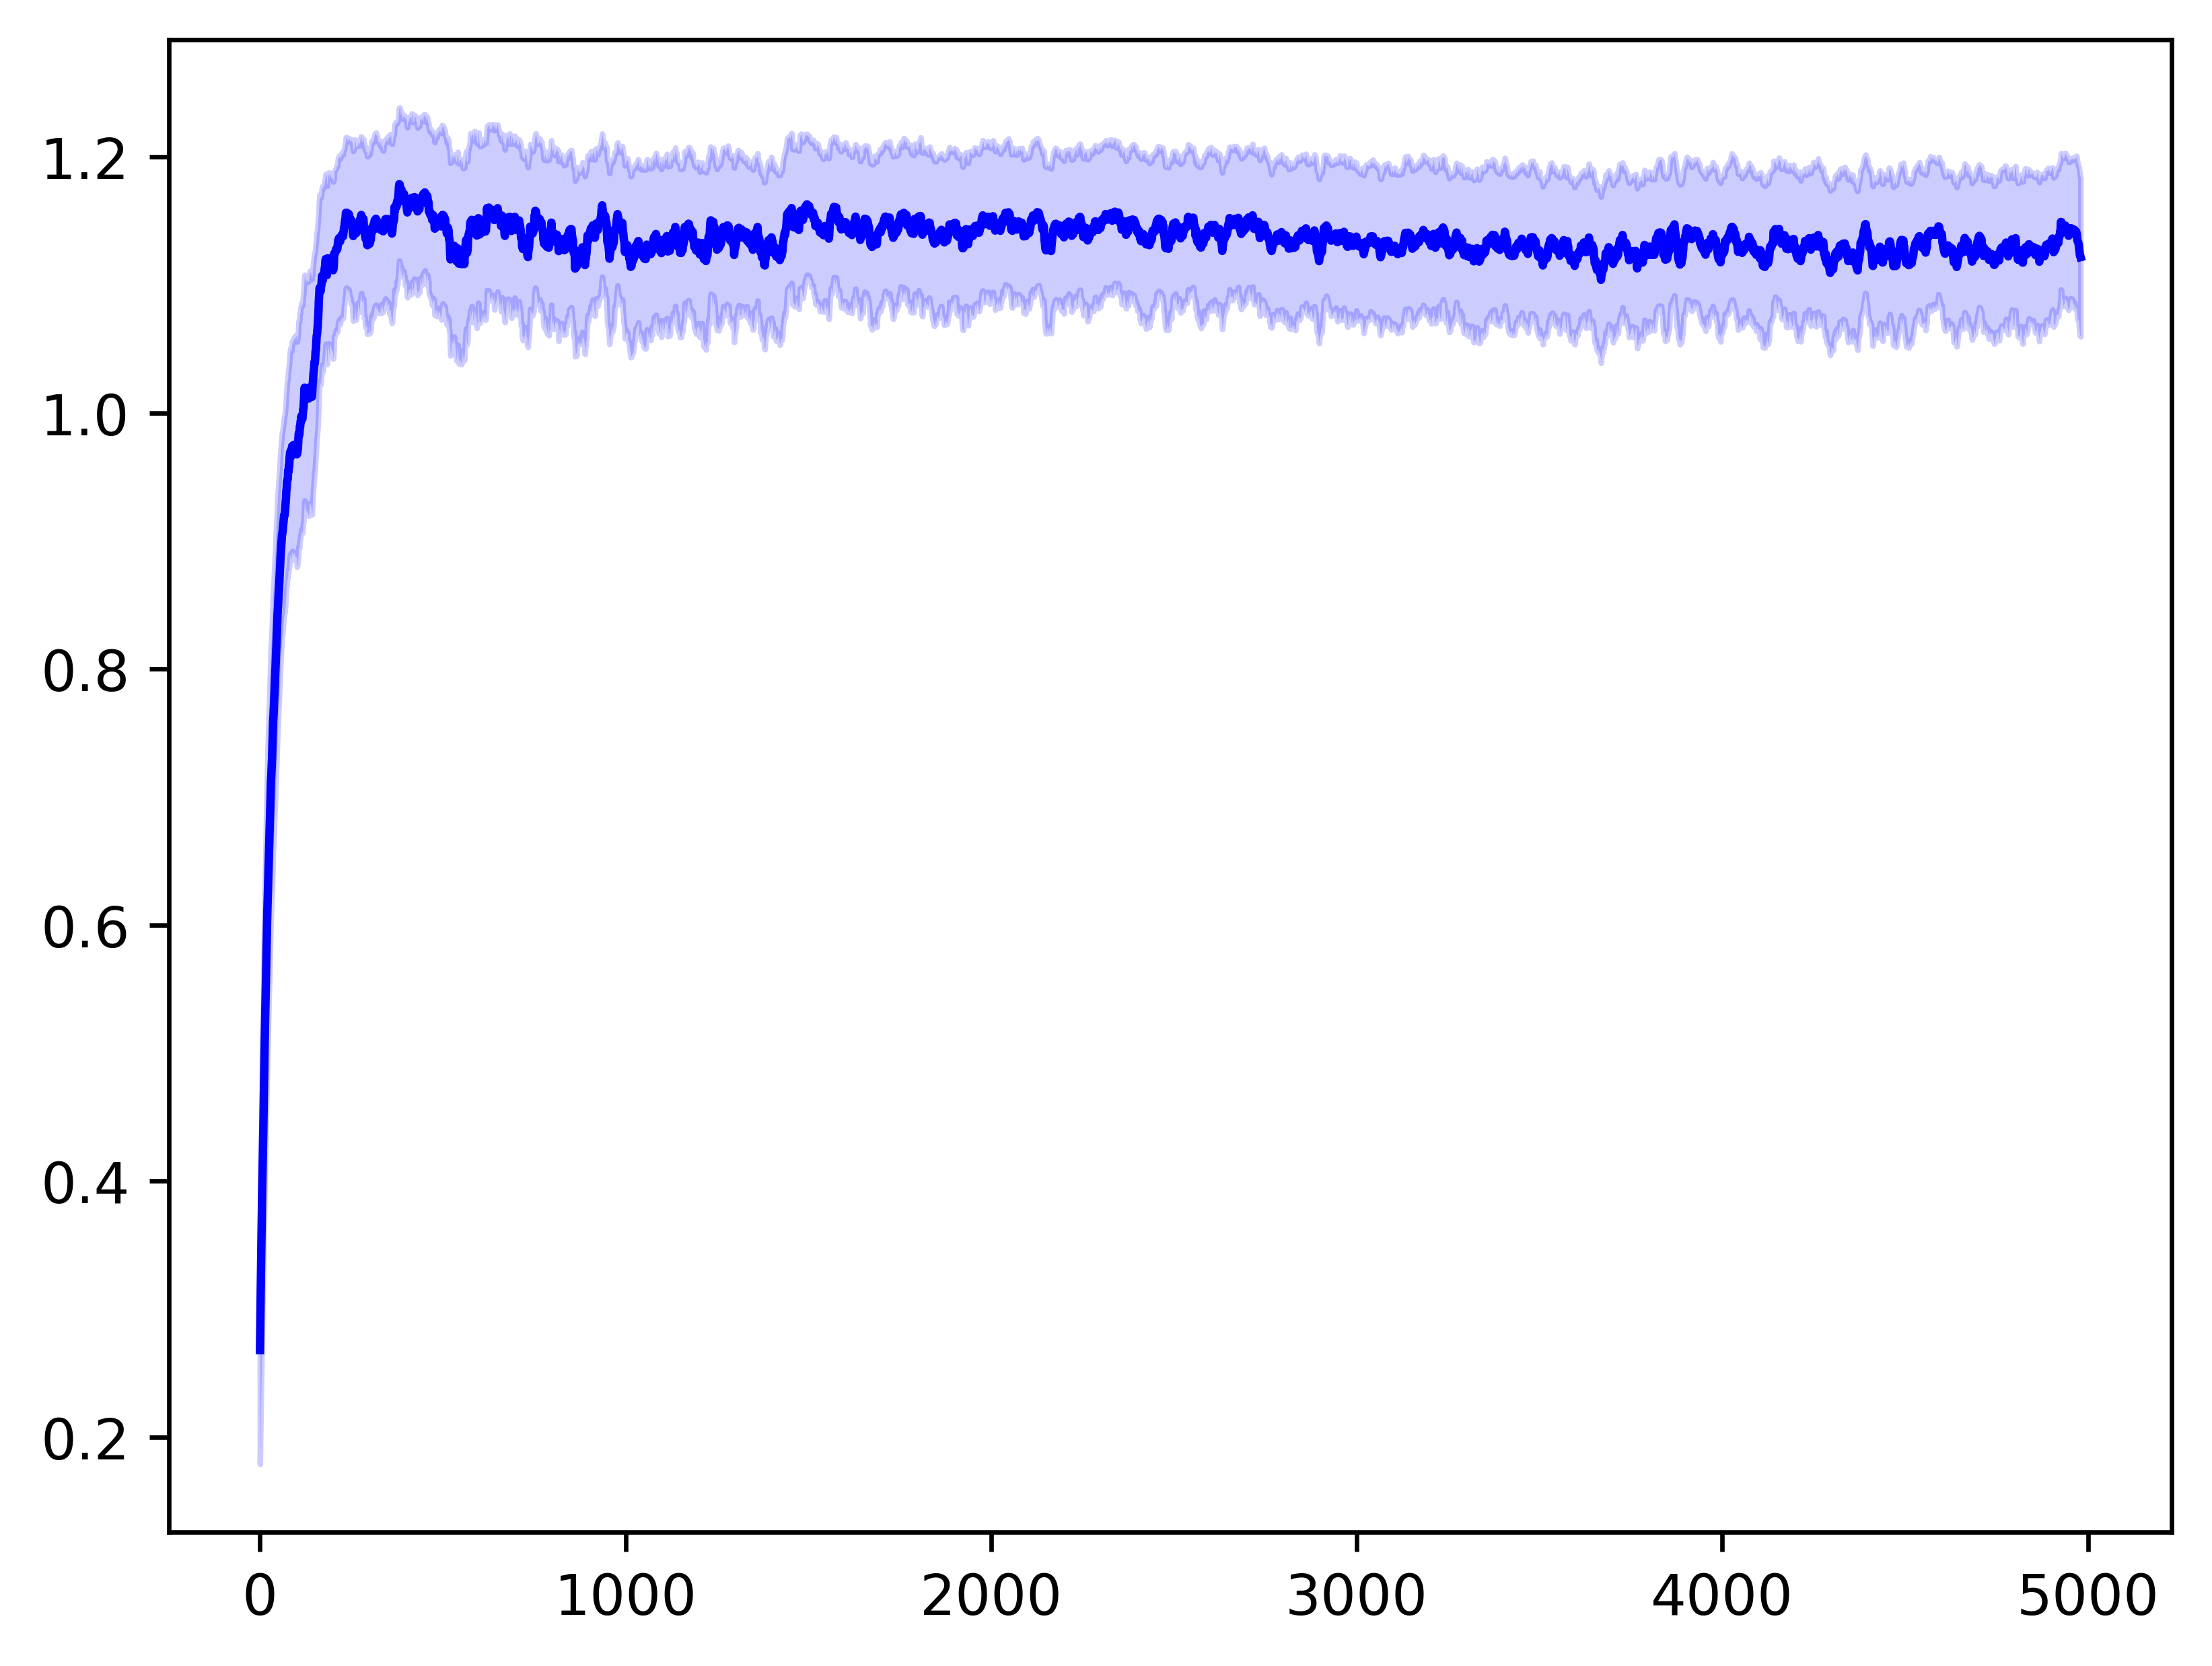

In [141]:
# Variables a guardar para entropy plot
d = entropy_data['NSEC']

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

# Layer activity - single

In [110]:
# Variables a computar para reward plot
window_width = 20
data_contextact = data['SEC']['contextual_relact']
data_contextact = np.asarray(data_contextact, dtype=np.float32)

mean = np.mean(data_contextact, axis=0)
yerr = np.std(data_contextact, axis=0) / math.sqrt(len(data_contextact))

data_contextact_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
data_contextact_mavecr = (data_contextact_cumsum[window_width:] - data_contextact_cumsum[:-window_width]) / window_width

data_contextact_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
data_contextact_mavecr_std = (data_contextact_cumsum_std[window_width:] - data_contextact_cumsum_std[:-window_width]) / window_width

min_val = data_contextact_mavecr - data_contextact_mavecr_std
max_val = data_contextact_mavecr + data_contextact_mavecr_std
length = data_contextact_mavecr_std.shape[0]

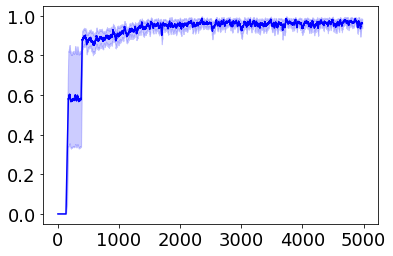

In [111]:
# Variables a guardar para reward plot
plt.plot(data_contextact_mavecr, label="Reactive", color='blue')

plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

# Layer activity - all

In [289]:
contextact_data = {}
window_width = 20

for model in models:

    data_contextact = data[model]['contextual_relact']
    data_contextact = np.asarray(data_contextact, dtype=np.float32)
    print("data_contextact_sum ", np.sum(data_contextact))
    if np.sum(data_contextact) > 0:                       
        if len(data_contextact[0]) > 5000: 
            data_half = np.hsplit(data_contextact, 2)
            data_contextact = data_half[0]

        mean = np.mean(data_contextact, axis=0)
        yerr = np.std(data_contextact, axis=0) / math.sqrt(len(data_contextact))

        data_contextact_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
        data_contextact_mavecr = (data_contextact_cumsum[window_width:] - data_contextact_cumsum[:-window_width]) / window_width

        data_contextact_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
        data_contextact_mavecr_std = (data_contextact_cumsum_std[window_width:] - data_contextact_cumsum_std[:-window_width]) / window_width

        contextact = {}
        contextact['mavecr'] = data_contextact_mavecr
        contextact['mavecr_std'] = data_contextact_mavecr_std
        contextact['min_val'] = data_contextact_mavecr - data_contextact_mavecr_std
        contextact['max_val'] = data_contextact_mavecr + data_contextact_mavecr_std
        contextact['length'] = data_contextact_mavecr_std.shape[0]

        contextact_data[model] = contextact

save_plot_data(contextact_data, 'contextact', file_path)

data_contextact_sum  96378.19
data_contextact_sum  90639.14
data_contextact_sum  0.0
data_contextact_sum  0.0
data_contextact_sum  88550.22
data_contextact_sum  88308.81
data_contextact_sum  88284.945
data_contextact_sum  91976.25
data_contextact_sum  89924.195
data_contextact_sum  72950.41
data_contextact_sum  72950.41
data_contextact_sum  92025.56


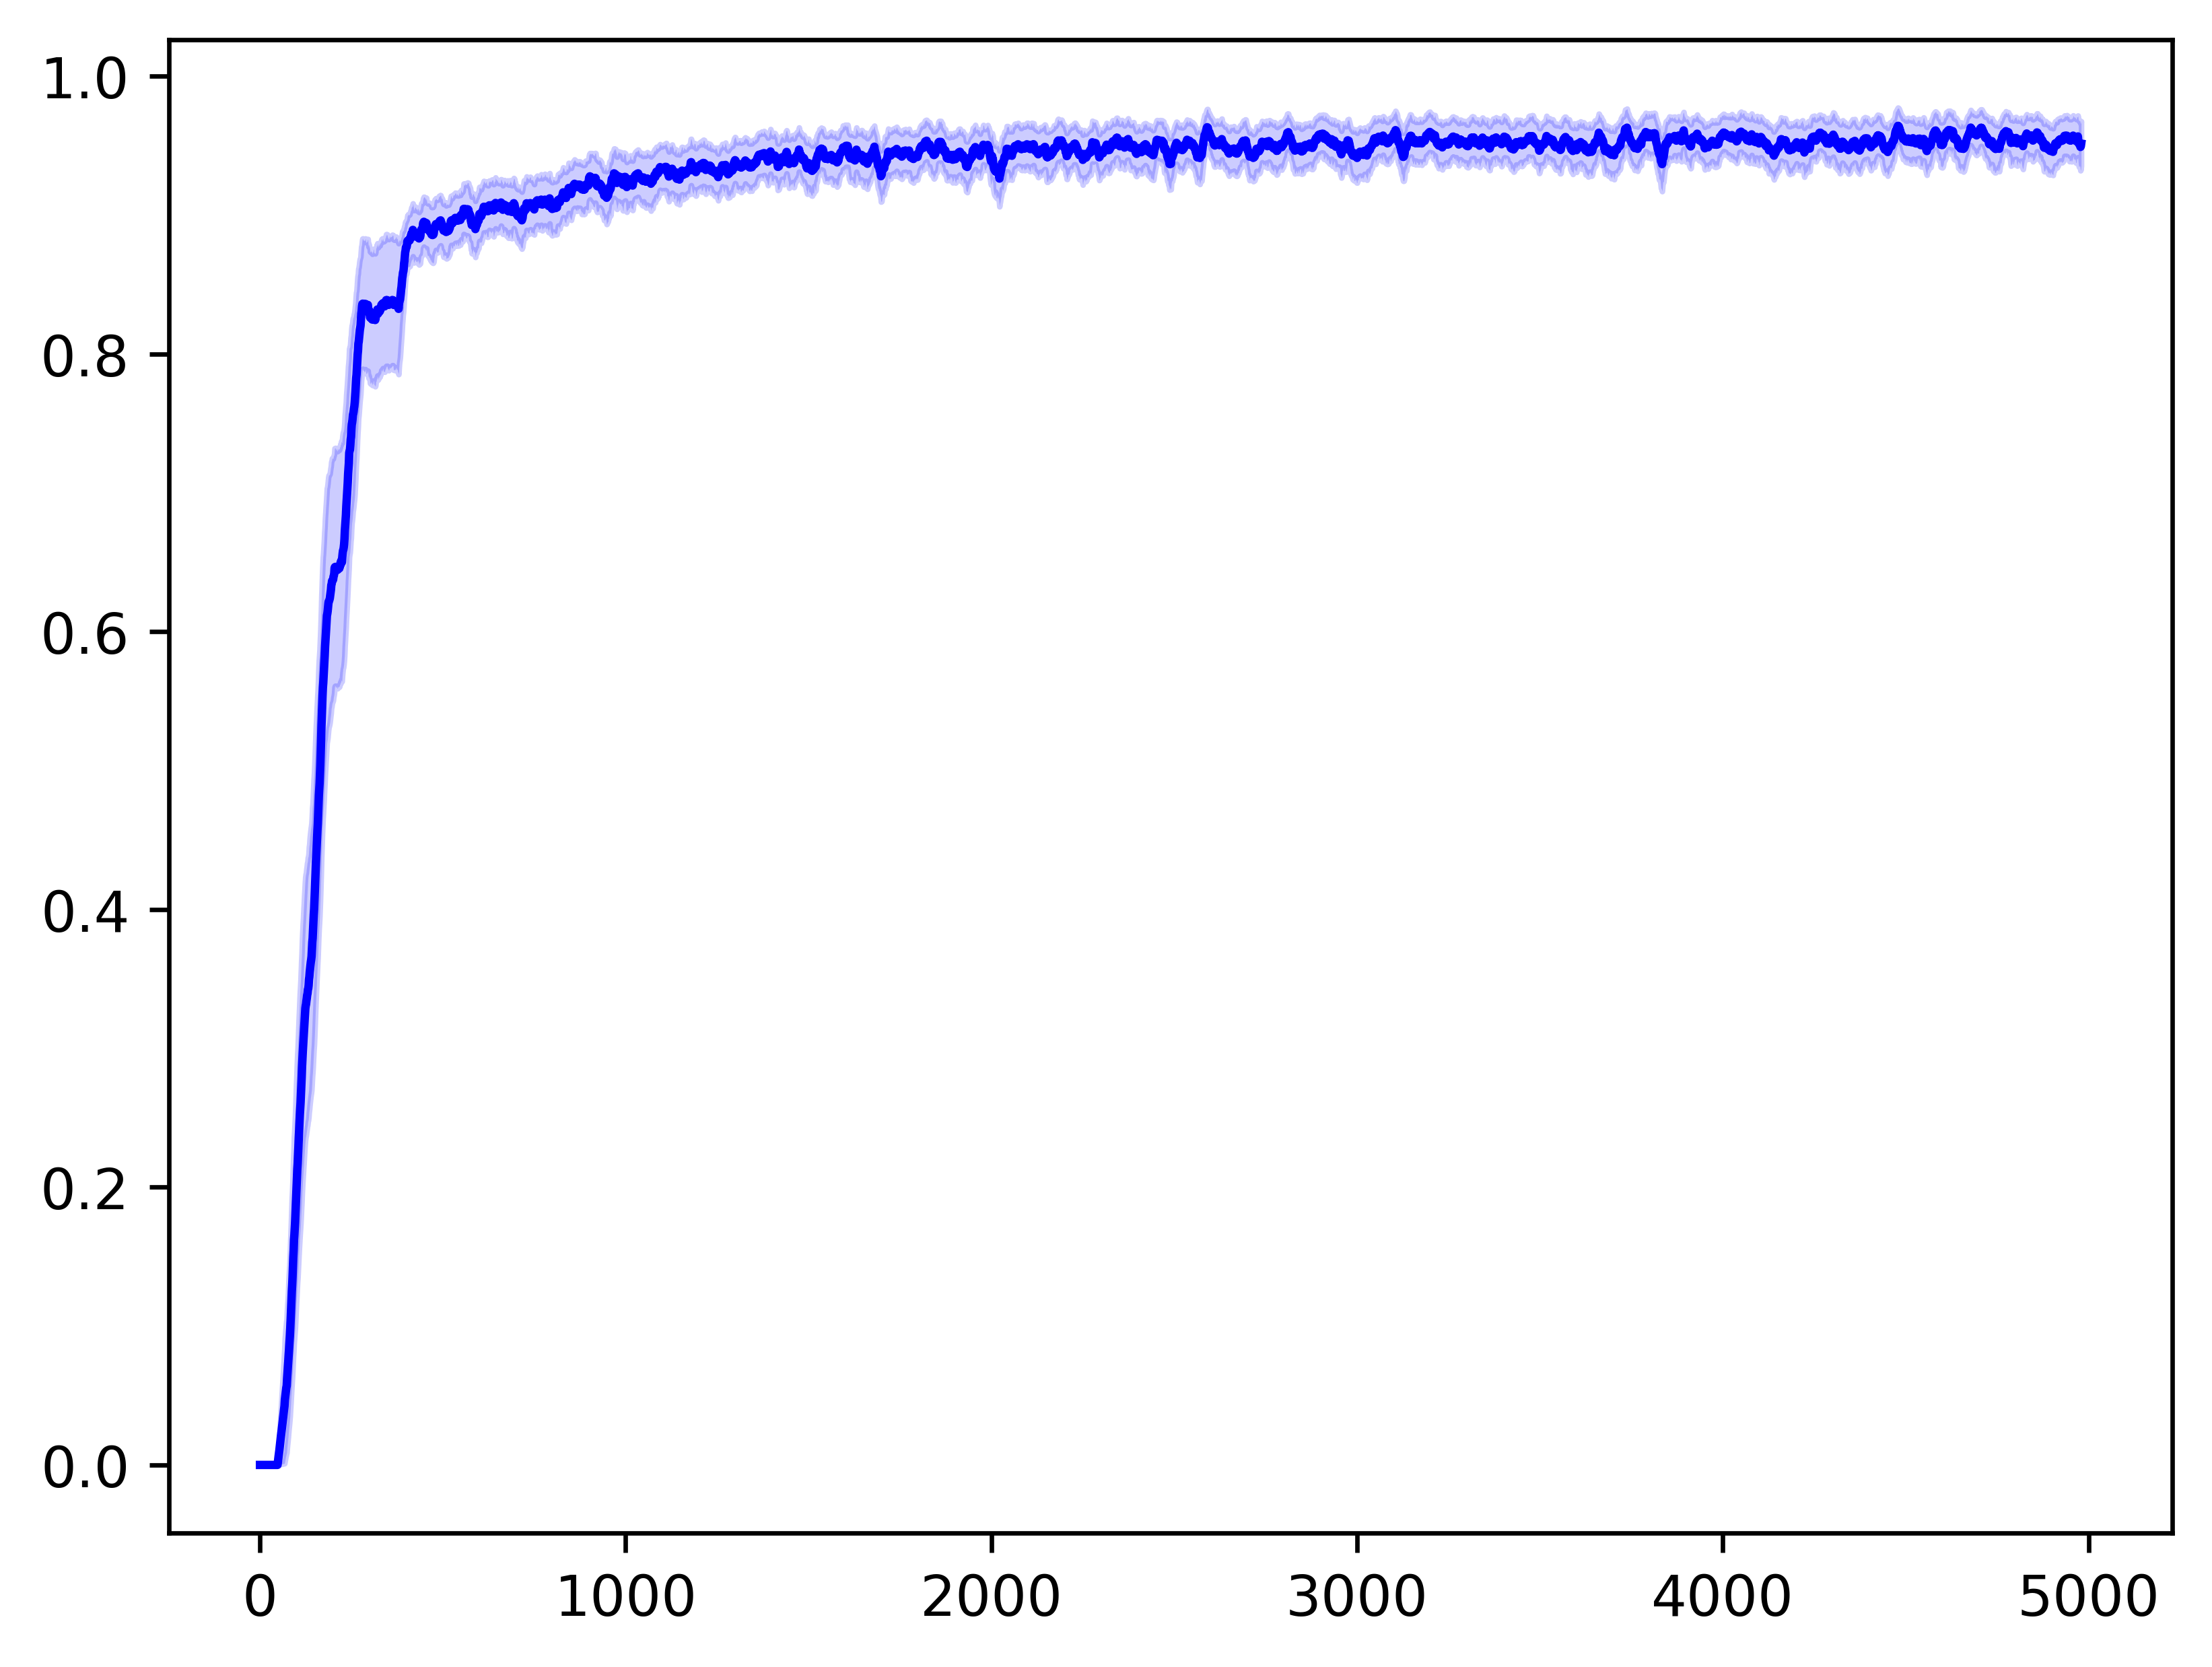

In [290]:
# Variables a guardar para entropy plot
d = contextact_data['SEC']

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)